In [1]:
%load_ext autoreload
%autoreload 2

This notebook takes the AOI from the previous notebook and prepares SLC id pairing (aka "enumeration") for submission to the Hyp3-ISCE2 API.

There are two general steps:

1. Create a stack of SLCs from the associated frames covering an AOI.
2. Pair the SLCs (enumeration) for preparation to submit to the Hyp3 API

For each steps, we serialize the data. Note, the first step can be used for multiple enumeration strategies.

Want to note the following definition of terms. We use AOI to describe the initial area of interest e.g. "US CONUS" or "East Coast". We will also use the term "track-AOI" which here allows us to do some accounting that will be helpful for submitting jobs to the API. We are grouping IFGs based on the Sentinel-1 track it falls into. More precise details are in described below.

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series,
                                 gdf2frames)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm
from pathlib import Path
from itertools import starmap
import yaml
from data_model import enumParams

# Paramaters

For reuse - we store the enumeration parameters in a yaml file. Ideally, the yaml file changes more than this notebook.

In [3]:
YAML_FILE = 'enum_configs/turkey_2024-02.yml'
RECOMPUTE_STACKS = False

# Load Parameters

In [4]:
PARAMS = enumParams.from_yaml(YAML_FILE)
PARAMS.__dict__

{'temporal_baseline_days': [0],
 'n_secondaries_per_reference': [3],
 'aoi_name': 'turkey',
 'n_seeds': 2,
 'track_numbers': [94, 21, 123, 14, 116, 43],
 'data_directory': 'out',
 'date_of_enum': datetime.date(2024, 2, 14),
 'stack_dir': PosixPath('out/turkey__tb_0__neigh_3/stack'),
 'enum_dir': PosixPath('out/turkey__tb_0__neigh_3/enum'),
 'yaml_path': PosixPath('out/turkey__tb_0__neigh_3/enum_params_2024-02-14.yml'),
 'weather_model': None,
 'month_constraint': None,
 'exclusive_month_constraints': False,
 'aoi_geojson_path': PosixPath('AOIs/turkey.geojson'),
 'valid_date_ranges': [[datetime.datetime(2023, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2024, 12, 1, 0, 0, tzinfo=datetime.timezone.utc)]],
 'enum_parent_dir': PosixPath('out/turkey__tb_0__neigh_3'),
 'yaml_path_record': PosixPath('enum_configs/turkey_2024-02.yml')}

In [5]:
yaml_record = PARAMS.to_yaml()
yaml_record

PosixPath('enum_configs/turkey_2024-02.yml')

# Load AOI

<Axes: >

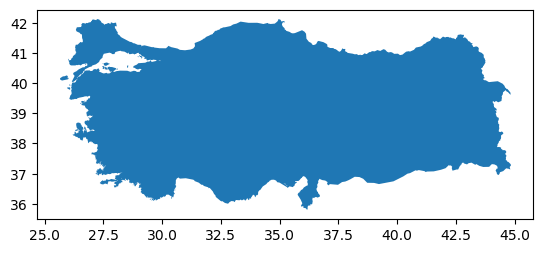

In [6]:
df_aoi = gpd.read_file(PARAMS.aoi_geojson_path)
# This ensures we only get the mainland part
df_aoi.plot()

# Get Frames overlapping AOI

This first cell gets the spatially fixed frames overlapping the AOI and possibly the provided track numbers.

In [7]:
aoi_geo = df_aoi.geometry.unary_union
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=PARAMS.track_numbers)
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,2014,east,14,14,"POLYGON Z ((35.17486 35.07706 0.00000, 35.0927..."
1,2015,east,14,14,"POLYGON Z ((34.90215 36.23914 0.00000, 34.7385..."
2,2016,east,14,14,"POLYGON Z ((34.62517 37.40160 0.00000, 34.4182..."
3,2017,east,14,14,"POLYGON Z ((34.34425 38.56207 0.00000, 34.0903..."
4,2018,east,14,14,"POLYGON Z ((34.04997 39.73767 0.00000, 34.0545..."


Let's remove frames that have less than 25% overlap with our AOI. This ensures ISCE2 will have roughly enough area to process.

In [8]:
intersection_geo = df_frames_all.geometry.intersection(aoi_geo)
with warnings.catch_warnings():
    # yes, we are computing areas in lat/lon - that's ok at these latitudes
    warnings.simplefilter("ignore", category=UserWarning)
    percent_overlap = intersection_geo.area / df_frames_all.geometry.area
df_frames = df_frames_all[percent_overlap >= .2].reset_index(drop=True)
df_frames = df_frames.explode(index_parts=True)
frames = gdf2frames(df_frames)

(34.60557697421325, 42.89795864684709)

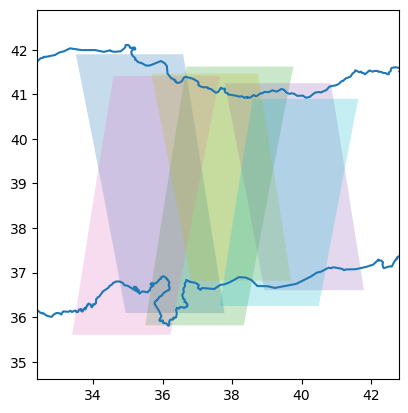

In [9]:
fig, ax = plt.subplots()
df_aoi.geometry.boundary.plot(ax=ax)
df_frames_by_track = df_frames.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        #legend=True
                       )
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a "stack" refers to obtaining all the SLC's that cover spatially fixed frames on a given track (you can only do InSAR with a fixed SAR geometry! i.e. on a fixed track). See [frame-enumerator](https://github.com/ACCESS-Cloud-Based-InSAR/s1-frame-enumerator) repository for more details about our terminology related to stacks, frames and enumeration of interferometric pairs.

We will serialize each stack to a geojson. If `RECOMPUTE_STACKS` is `True`, then will overwrite existing stacks to retreive the most-up-to-date stack. Our generation of a stack relies on simply hitting the ASF API through its python [library](https://github.com/asfadmin/Discovery-asf_search).

Creating a workflow that "updates" an existing serialized stack is beyond the scope of this notebook, and quite frankly, not recommended, as such would require lots of book-keeping that would significantly bloat this notebook and the enumeration code. Acquiring multiple stacks covering a US coast generated in less than 30 minutes seems reasonable. Also, since the serialization of each stack is done, the stack data can be reused without re-running it.

In [10]:
all_tracks = df_frames.track_number_min.unique().tolist()
all_tracks[:3]

[14, 21, 43]

An important book-keeping piece is that we are going to group the frames by track *and* by its connected component into what we will also call a "track-AOIs". These "track-AOIs" are simply the groups we submit jobs to Hyp3. Put in a slightly different way, a "track-AOI" is simply a contiguous set of frames that overlap our AOI. Note that a single track can become disconnected based on our AOI (this is often cause by concavity in the original AOI). We will name these track AOIs based on `track{N}` and if there are additional track areas we will call them `track{N}-_{index}` e.g. `track23, track23_1, ...`.

**Warning**: We have the initial "AOI" which refers to a general area of interest for a science use case such as "US CONUS" or "Tibet" and now we *also* are grouping frames into "track-AOIs" for accounting jobs submitted to Hyp3.

Below we create dictionary with key `track_AOI_ID` and value a list of frames within that area. A frame is simply a data container

In [11]:
def id_formatter(row: pd.Series):
    """Returns 'track<track_number>' for first instance and then 'track<track_number>_k' for each subsequent k index"""
    if row['level_1']:
        return f"track{row['track_number_min']}_{row['level_1']}"
    else:
        return f"track{row['track_number_min']}"

df_track_aois = df_frames_by_track.explode().reset_index(drop=False)
df_track_aois['track_aoi_id'] = df_track_aois.apply(id_formatter, axis=1)
df_track_aois.head()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_61689/2628663778.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_track_aois = df_frames_by_track.explode().reset_index(drop=False)


,level_0,level_1,track_number_min,frame_id,hemisphere,track_number_max,geometry,track_aoi_id
0,0,0,14,2015,east,14,"POLYGON Z ((34.74262 36.91827 0.00000, 34.6606...",track14
1,1,0,21,3150,east,21,"POLYGON Z ((35.60395 36.33929 0.00000, 35.7334...",track21
2,2,0,43,6523,east,43,"POLYGON Z ((38.85392 36.93174 0.00000, 38.6504...",track43
3,3,0,94,14612,east,94,"POLYGON Z ((33.53795 36.29530 0.00000, 33.6336...",track94
4,4,0,116,17966,east,116,"POLYGON Z ((36.50713 38.12447 0.00000, 36.4623...",track116


In [12]:
track2frames = {row['track_aoi_id']: [f for f in frames 
                                      if row['track_number_min'] in f.track_numbers 
                                      if row['geometry'].intersects(f.frame_geometry)
                       ] 
                for _, row in df_track_aois.iterrows()}

keys = list(track2frames.keys())
track2frames[keys[0]]

[S1Frame(frame_id=2015, hemisphere='east', track_numbers=[14], frame_geometry=<POLYGON Z ((34.902 36.239 0, 34.739 36.918 0, 34.743 36.918 0, 34.661 37.25...>, footprint_geometry=<POLYGON ((37.68 36.604, 37.822 35.902, 36.946 35.787, 36.922 35.897, 36.47 ...>),
 S1Frame(frame_id=2016, hemisphere='east', track_numbers=[14], frame_geometry=<POLYGON Z ((34.625 37.402 0, 34.418 38.245 0, 34.38 38.417 0, 37.312 38.417...>, footprint_geometry=<POLYGON ((37.587 37.063, 36.697 36.948, 36.673 37.058, 36.213 36.996, 35.69...>),
 S1Frame(frame_id=2017, hemisphere='east', track_numbers=[14], frame_geometry=<POLYGON Z ((34.344 38.562 0, 34.09 39.578 0, 37.074 39.578 0, 37.252 38.72 ...>, footprint_geometry=<POLYGON ((37.314 38.409, 37.352 38.223, 36.448 38.11, 36.424 38.219, 35.957...>),
 S1Frame(frame_id=2018, hemisphere='east', track_numbers=[14], frame_geometry=<POLYGON Z ((34.05 39.738 0, 34.055 39.738 0, 33.8 40.738 0, 36.834 40.738 0...>, footprint_geometry=<POLYGON ((37.073 39.588, 37.115 39

For each `track_aoi_id`, we save the stack as `track{N}-{AOI_NAME}`, hopefully the multiple use of "AOIs" is clear.

In [13]:
track_log = tqdm(total=0, position=0, bar_format='{desc}')

def get_s1_stack_and_serialize(track_aoi_id: str, frames: list, recompute_stack=RECOMPUTE_STACKS):
    if not frames:
        warnings.warn('No frames submitted')
        return
    track_stack_path = PARAMS.stack_dir / f'{track_aoi_id}-{PARAMS.aoi_name}.geojson'
    track_log.set_description_str(f'Current track: {track_stack_path}')
    if track_stack_path.exists() and (not recompute_stack):
        return track_stack_path
    df_stack = get_s1_stack(frames, minimum_coverage_ratio_per_frame=.2, minimum_coverage_ratio_per_pass=.8)
    if df_stack.empty:
        warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
    df_stack.to_file(track_stack_path, driver='GeoJSON')
    return track_stack_path

In [14]:
input_frame_data = list(track2frames.items())
stack_paths = list(starmap(get_s1_stack_and_serialize, tqdm(input_frame_data)))


Current track: out/turkey__tb_0__neigh_3/stack/track14-turkey.geojson              | 0/6 [00:00<?, ?it/s]






/Users/cmarshak/miniforge3/envs/aria_hyp3_env/lib/python3.12/site-packages/s1_frame_enumerator/s1_stack_formatter.py:60: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  df_formatted['stack_repeat_pass_id'] = df_formatted.groupby(['stack_repeat_pass_id']).grouper.group_info[0]

Current track: out/turkey__tb_0__neigh_3/stack/track21-turkey.geojson      | 1/6 [00:25<02:09, 25.92s/it]






/Users/cmarshak/miniforge3/envs/aria_hyp3_env/lib/python3.12/site-packages/s1_frame_enumerator/s1_stack_formatter.py:60: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  df_formatted['stack_repeat_pass_id'] = df_formatted.groupby(['stack_repeat_pass_id']).grouper.group_info[0]

Current track: out/turkey__tb_0__neigh_3/stack/track43-turkey.geojson      | 2/6 [00:57<01:57, 29.32s

# Generate IFG Pairs

Our goal in our enumeration scheme is to provide numerous pairings so scientist later can figure out what are the optimal time-series for their needs.

The basic enumeration is we loop through `min_temporal_baseline` and then find pairings based on the connected time series extract.

Additionally, we perform an independent enumeration of pairs (if `MONTH_CONSTRAINTS` is non-empty or not `None`), where we do the same as described above after we filter the stack based on those months provided in the `enum_params.yml`. This allows us to select months with likely high-coherence.

In [15]:
df_stack_sample = gpd.read_file(stack_paths[0])
df_stack_sample.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20141006T153252_20141006T1533...,2014-10-06T15:32:52+00:00,2014-10-06T15:33:21+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,14,VV+VH,2711,IW,9.039156,0,2014-10-06 00:00:00+00:00,"POLYGON ((34.98208 35.82318, 35.38430 34.12088..."
1,S1A_IW_SLC__1SDV_20141006T153318_20141006T1533...,2014-10-06T15:33:18+00:00,2014-10-06T15:33:45+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,14,VV+VH,2711,IW,8.694285,0,2014-10-06 00:00:00+00:00,"POLYGON ((34.61749 37.31553, 35.01399 35.67127..."
2,S1A_IW_SLC__1SDV_20141006T153343_20141006T1534...,2014-10-06T15:33:43+00:00,2014-10-06T15:34:10+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,14,VV+VH,2711,IW,8.694754,0,2014-10-06 00:00:00+00:00,"POLYGON ((34.27697 38.81182, 34.68131 37.16796..."
3,S1A_IW_SLC__1SDV_20141006T153408_20141006T1534...,2014-10-06T15:34:08+00:00,2014-10-06T15:34:35+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,14,VV+VH,2711,IW,8.694424,0,2014-10-06 00:00:00+00:00,"POLYGON ((33.89408 40.30224, 34.30780 38.65945..."
4,S1A_IW_SLC__1SDV_20141006T153433_20141006T1535...,2014-10-06T15:34:33+00:00,2014-10-06T15:35:00+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,14,VV+VH,2711,IW,8.688400,0,2014-10-06 00:00:00+00:00,"POLYGON ((33.51044 41.79276, 33.93435 40.15110..."


In [16]:
IFG_COLUMNS = ['reference', 'secondary', 'reference_date', 'secondary_date', 'frame_id', 'geometry']
def encode_dataframe_for_serialization(df_ifg: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ifg['reference_date'] = df_ifg['reference_date'].dt.date.astype(str)
    df_ifg['secondary_date'] = df_ifg['secondary_date'].dt.date.astype(str)
    
    df_ifg['reference'] = df_ifg['reference'].map(lambda l: ' '.join(l))
    df_ifg['secondary'] = df_ifg['secondary'].map(lambda l: ' '.join(l))
    
    df_ifg.crs = CRS.from_epsg(4326)
    return df_ifg  


def enumerate_one_stack(stack_path: Path,
                        temporal_baselines_days: int, 
                        neighbors: int | list[int],
                        n_init_seeds: int,
                        month_constraints: list,
                        exclusive_month_constraints: bool,
                        valid_date_ranges: list):
    neighbors_lst = neighbors if isinstance(neighbors, list) else [neighbors] * len(temporal_baselines_days)
    
    df_stack = gpd.read_file(stack_path)
    
    stack_path_stem = stack_path.stem
    track_aoi_key, aoi_name = stack_path_stem.split('-')
    
    frames = track2frames[track_aoi_key]
    enum_data_path_track_aoi = PARAMS.enum_dir / f'{track_aoi_key}-{aoi_name}.geojson'
    
    # We prepare an empty output dataframe in case any steps yeild empty frames
    df_ifg = gpd.GeoDataFrame(columns=IFG_COLUMNS)
    df_ifg.crs = CRS.from_epsg(4326)

    all_data = []
    # Only enumerate if stack non-empty
    if not df_stack.empty:
        # We will loop through constraints and month constraints if desired
        month_constraints_enumeration = [] if exclusive_month_constraints else [False]
        if month_constraints:
            month_constraints_enumeration.append(True)            
        for constraint in month_constraints_enumeration:
            df_stack_temp = df_stack.copy()
            if constraint:
                months_in_stack = pd.to_datetime(df_stack_temp.repeat_pass_timestamp).dt.month
                ind = months_in_stack.isin(month_constraints)
                df_stack_temp = df_stack_temp[ind].reset_index(drop=True)
            if valid_date_ranges is not None:
                valid_date_ranges_ts = [(pd.to_datetime(t_0), pd.to_datetime(t_1))
                                        for (t_0, t_1) in valid_date_ranges]
                inds = [((df_stack_temp.repeat_pass_timestamp >= t_0) & (df_stack_temp.repeat_pass_timestamp <= t_1)) 
                        for (t_0, t_1) in valid_date_ranges_ts]
                ind = np.logical_or.reduce(inds)
                df_stack_temp = df_stack_temp[ind].reset_index(drop=True)
            if not df_stack_temp.empty:
                for neigh, tb in zip(neighbors_lst, temporal_baselines_days):
                    data = enumerate_gunw_time_series(df_stack_temp, 
                                                      tb, 
                                                      n_secondary_scenes_per_ref=neigh,
                                                      frames=frames,
                                                      n_init_seeds=n_init_seeds,
                                                      )
                    all_data += data

    # There are situations when the stack is non-empty and we have no pairs (literally one pass - see track 55)
    if all_data:
        df_ifg = gpd.GeoDataFrame(all_data)
        df_ifg = df_ifg.drop_duplicates(subset=['reference_date', 
                                                'secondary_date', 
                                                'frame_id']).reset_index(drop=True)
        df_ifg = encode_dataframe_for_serialization(df_ifg)
        
        # Write some important parameters
        df_ifg['track_aoi_key'] = track_aoi_key
        df_ifg['aoi_name'] = aoi_name
    
    df_ifg.to_file(enum_data_path_track_aoi, driver='GeoJSON')
    return enum_data_path_track_aoi

In [17]:
def enumerate_one_stack_p(stack_path: Path):
    return enumerate_one_stack(stack_path,
                               temporal_baselines_days=PARAMS.temporal_baseline_days,
                               neighbors=PARAMS.n_secondaries_per_reference,
                               n_init_seeds=PARAMS.n_seeds,
                               exclusive_month_constraints=PARAMS.exclusive_month_constraints,
                               month_constraints=PARAMS.month_constraint,
                               valid_date_ranges=PARAMS.valid_date_ranges
                              )

In [18]:
ifg_data_paths = list(map(enumerate_one_stack_p, tqdm(stack_paths[:])))


  0%|                                                                              | 0/6 [00:00<?, ?it/s]

Date Pairs:   0%|                                                                 | 0/81 [00:00<?, ?it/s]

Date Pairs:   5%|██▊                                                      | 4/81 [00:00<00:02, 33.61it/s]

Date Pairs:  10%|█████▋                                                   | 8/81 [00:00<00:02, 34.50it/s]

Date Pairs:  15%|████████▎                                               | 12/81 [00:00<00:01, 34.92it/s]

Date Pairs:  20%|███████████                                             | 16/81 [00:00<00:01, 34.93it/s]

Date Pairs:  25%|█████████████▊                                          | 20/81 [00:00<00:01, 35.60it/s]

Date Pairs:  30%|████████████████▌                                       | 24/81 [00:00<00:01, 35.75it/s]

Date Pairs:  35%|███████████████████▎                                    | 28/81 [00:00<00:01, 35.94it/s]

Date Pairs:  40%|███████████████████

Date Pairs:  77%|█████████████▊    | 195/254 [00:24<00:07,  7.56it/s]

Date Pairs:  77%|█████████████▉    | 196/254 [00:25<00:07,  7.65it/s]

Date Pairs:  78%|█████████████▉    | 197/254 [00:25<00:07,  7.66it/s]

Date Pairs:  78%|██████████████    | 198/254 [00:25<00:07,  7.72it/s]

Date Pairs:  78%|██████████████    | 199/254 [00:25<00:07,  7.73it/s]

Date Pairs:  79%|██████████████▏   | 200/254 [00:25<00:06,  7.74it/s]

Date Pairs:  79%|██████████████▏   | 201/254 [00:25<00:06,  7.75it/s]

Date Pairs:  80%|██████████████▎   | 202/254 [00:25<00:06,  7.78it/s]

Date Pairs:  80%|██████████████▍   | 203/254 [00:25<00:06,  7.76it/s]

Date Pairs:  80%|██████████████▍   | 204/254 [00:26<00:06,  7.73it/s]

Date Pairs:  81%|██████████████▌   | 205/254 [00:26<00:06,  7.75it/s]

Date Pairs:  81%|██████████████▌   | 206/254 [00:26<00:06,  7.79it/s]

Date Pairs:  81%|██████████████▋   | 207/254 [00:26<00:06,  7.81it/s]

Date Pairs:  82%|██████████████▋   | 208/254 [00:26<00:05,  7.83it/s]

Date P

Date Pairs:  16%|███                | 46/282 [00:04<00:25,  9.26it/s]

Date Pairs:  17%|███▏               | 47/282 [00:05<00:25,  9.28it/s]

Date Pairs:  17%|███▏               | 48/282 [00:05<00:25,  9.22it/s]

Date Pairs:  17%|███▎               | 49/282 [00:05<00:25,  9.26it/s]

Date Pairs:  18%|███▎               | 50/282 [00:05<00:24,  9.30it/s]

Date Pairs:  18%|███▍               | 51/282 [00:05<00:24,  9.31it/s]

Date Pairs:  18%|███▌               | 52/282 [00:05<00:24,  9.34it/s]

Date Pairs:  19%|███▌               | 53/282 [00:05<00:24,  9.37it/s]

Date Pairs:  19%|███▋               | 54/282 [00:05<00:24,  9.39it/s]

Date Pairs:  20%|███▋               | 55/282 [00:05<00:24,  9.38it/s]

Date Pairs:  20%|███▊               | 56/282 [00:06<00:24,  9.38it/s]

Date Pairs:  20%|███▊               | 57/282 [00:06<00:24,  9.31it/s]

Date Pairs:  21%|███▉               | 58/282 [00:06<00:24,  9.33it/s]

Date Pairs:  21%|███▉               | 59/282 [00:06<00:23,  9.37it/s]

Date P

Date Pairs:  54%|█████████▋        | 152/282 [00:16<00:13,  9.40it/s]

Date Pairs:  54%|█████████▊        | 153/282 [00:16<00:13,  9.42it/s]

Date Pairs:  55%|█████████▊        | 154/282 [00:16<00:13,  9.40it/s]

Date Pairs:  55%|█████████▉        | 155/282 [00:16<00:13,  9.42it/s]

Date Pairs:  55%|█████████▉        | 156/282 [00:16<00:13,  9.43it/s]

Date Pairs:  56%|██████████        | 157/282 [00:16<00:13,  9.40it/s]

Date Pairs:  56%|██████████        | 158/282 [00:16<00:13,  9.42it/s]

Date Pairs:  56%|██████████▏       | 159/282 [00:17<00:13,  9.45it/s]

Date Pairs:  57%|██████████▏       | 160/282 [00:17<00:12,  9.46it/s]

Date Pairs:  57%|██████████▎       | 161/282 [00:17<00:12,  9.46it/s]

Date Pairs:  57%|██████████▎       | 162/282 [00:17<00:12,  9.44it/s]

Date Pairs:  58%|██████████▍       | 163/282 [00:17<00:12,  9.44it/s]

Date Pairs:  58%|██████████▍       | 164/282 [00:17<00:12,  9.42it/s]

Date Pairs:  59%|██████████▌       | 165/282 [00:17<00:12,  9.32it/s]

Date P

Date Pairs:  91%|████████████████▍ | 258/282 [00:27<00:02,  9.45it/s]

Date Pairs:  92%|████████████████▌ | 259/282 [00:27<00:02,  9.40it/s]

Date Pairs:  92%|████████████████▌ | 260/282 [00:27<00:02,  9.40it/s]

Date Pairs:  93%|████████████████▋ | 261/282 [00:28<00:02,  9.39it/s]

Date Pairs:  93%|████████████████▋ | 262/282 [00:28<00:02,  9.42it/s]

Date Pairs:  93%|████████████████▊ | 263/282 [00:28<00:02,  9.40it/s]

Date Pairs:  94%|████████████████▊ | 264/282 [00:28<00:01,  9.43it/s]

Date Pairs:  94%|████████████████▉ | 265/282 [00:28<00:01,  9.42it/s]

Date Pairs:  94%|████████████████▉ | 266/282 [00:28<00:01,  9.42it/s]

Date Pairs:  95%|█████████████████ | 267/282 [00:28<00:01,  9.40it/s]

Date Pairs:  95%|█████████████████ | 268/282 [00:28<00:01,  9.42it/s]

Date Pairs:  95%|█████████████████▏| 269/282 [00:28<00:01,  9.43it/s]

Date Pairs:  96%|█████████████████▏| 270/282 [00:29<00:01,  9.45it/s]

Date Pairs:  96%|█████████████████▎| 271/282 [00:29<00:01,  9.41it/s]

Date P

Date Pairs:   8%|█▌                 | 14/175 [00:01<00:17,  9.36it/s]

Date Pairs:   9%|█▋                 | 15/175 [00:01<00:17,  9.40it/s]

Date Pairs:   9%|█▋                 | 16/175 [00:01<00:16,  9.42it/s]

Date Pairs:  10%|█▊                 | 17/175 [00:01<00:16,  9.39it/s]

Date Pairs:  10%|█▉                 | 18/175 [00:01<00:16,  9.37it/s]

Date Pairs:  11%|██                 | 19/175 [00:02<00:16,  9.36it/s]

Date Pairs:  11%|██▏                | 20/175 [00:02<00:16,  9.36it/s]

Date Pairs:  12%|██▎                | 21/175 [00:02<00:16,  9.36it/s]

Date Pairs:  13%|██▍                | 22/175 [00:02<00:16,  9.40it/s]

Date Pairs:  13%|██▍                | 23/175 [00:02<00:16,  9.40it/s]

Date Pairs:  14%|██▌                | 24/175 [00:02<00:16,  9.35it/s]

Date Pairs:  14%|██▋                | 25/175 [00:02<00:16,  9.33it/s]

Date Pairs:  15%|██▊                | 26/175 [00:02<00:15,  9.32it/s]

Date Pairs:  15%|██▉                | 27/175 [00:02<00:15,  9.32it/s]

Date P

Date Pairs:  69%|████████████▎     | 120/175 [00:12<00:05,  9.44it/s]

Date Pairs:  69%|████████████▍     | 121/175 [00:12<00:05,  9.38it/s]

Date Pairs:  70%|████████████▌     | 122/175 [00:12<00:05,  9.39it/s]

Date Pairs:  70%|████████████▋     | 123/175 [00:13<00:05,  9.42it/s]

Date Pairs:  71%|████████████▊     | 124/175 [00:13<00:05,  9.43it/s]

Date Pairs:  71%|████████████▊     | 125/175 [00:13<00:05,  9.37it/s]

Date Pairs:  72%|████████████▉     | 126/175 [00:13<00:05,  9.32it/s]

Date Pairs:  73%|█████████████     | 127/175 [00:13<00:05,  9.29it/s]

Date Pairs:  73%|█████████████▏    | 128/175 [00:13<00:05,  9.28it/s]

Date Pairs:  74%|█████████████▎    | 129/175 [00:13<00:04,  9.27it/s]

Date Pairs:  74%|█████████████▎    | 130/175 [00:13<00:04,  9.27it/s]

Date Pairs:  75%|█████████████▍    | 131/175 [00:13<00:04,  9.26it/s]

Date Pairs:  75%|█████████████▌    | 132/175 [00:14<00:04,  9.28it/s]

Date Pairs:  76%|█████████████▋    | 133/175 [00:14<00:04,  9.32it/s]

Date P

Date Pairs:  13%|██▍                | 76/597 [00:04<00:31, 16.49it/s]

Date Pairs:  13%|██▍                | 78/597 [00:04<00:31, 16.49it/s]

Date Pairs:  13%|██▌                | 80/597 [00:04<00:31, 16.51it/s]

Date Pairs:  14%|██▌                | 82/597 [00:04<00:31, 16.52it/s]

Date Pairs:  14%|██▋                | 84/597 [00:05<00:31, 16.38it/s]

Date Pairs:  14%|██▋                | 86/597 [00:05<00:31, 16.44it/s]

Date Pairs:  15%|██▊                | 88/597 [00:05<00:30, 16.54it/s]

Date Pairs:  15%|██▊                | 90/597 [00:05<00:30, 16.58it/s]

Date Pairs:  15%|██▉                | 92/597 [00:05<00:30, 16.64it/s]

Date Pairs:  16%|██▉                | 94/597 [00:05<00:30, 16.67it/s]

Date Pairs:  16%|███                | 96/597 [00:05<00:30, 16.68it/s]

Date Pairs:  16%|███                | 98/597 [00:05<00:29, 16.69it/s]

Date Pairs:  17%|███               | 100/597 [00:06<00:29, 16.70it/s]

Date Pairs:  17%|███               | 102/597 [00:06<00:29, 16.70it/s]

Date P

Date Pairs:  48%|████████▋         | 288/597 [00:17<00:18, 16.61it/s]

Date Pairs:  49%|████████▋         | 290/597 [00:17<00:18, 16.63it/s]

Date Pairs:  49%|████████▊         | 292/597 [00:17<00:18, 16.65it/s]

Date Pairs:  49%|████████▊         | 294/597 [00:17<00:18, 16.66it/s]

Date Pairs:  50%|████████▉         | 296/597 [00:17<00:18, 16.64it/s]

Date Pairs:  50%|████████▉         | 298/597 [00:18<00:17, 16.63it/s]

Date Pairs:  50%|█████████         | 300/597 [00:18<00:17, 16.54it/s]

Date Pairs:  51%|█████████         | 302/597 [00:18<00:17, 16.54it/s]

Date Pairs:  51%|█████████▏        | 304/597 [00:18<00:17, 16.59it/s]

Date Pairs:  51%|█████████▏        | 306/597 [00:18<00:17, 16.62it/s]

Date Pairs:  52%|█████████▎        | 308/597 [00:18<00:17, 16.65it/s]

Date Pairs:  52%|█████████▎        | 310/597 [00:18<00:17, 16.67it/s]

Date Pairs:  52%|█████████▍        | 312/597 [00:18<00:17, 16.68it/s]

Date Pairs:  53%|█████████▍        | 314/597 [00:19<00:16, 16.70it/s]

Date P

Date Pairs:  84%|███████████████   | 500/597 [00:30<00:05, 16.68it/s]

Date Pairs:  84%|███████████████▏  | 502/597 [00:30<00:05, 16.64it/s]

Date Pairs:  84%|███████████████▏  | 504/597 [00:30<00:05, 16.67it/s]

Date Pairs:  85%|███████████████▎  | 506/597 [00:30<00:05, 16.68it/s]

Date Pairs:  85%|███████████████▎  | 508/597 [00:30<00:05, 16.69it/s]

Date Pairs:  85%|███████████████▍  | 510/597 [00:30<00:05, 16.67it/s]

Date Pairs:  86%|███████████████▍  | 512/597 [00:31<00:05, 16.69it/s]

Date Pairs:  86%|███████████████▍  | 514/597 [00:31<00:04, 16.70it/s]

Date Pairs:  86%|███████████████▌  | 516/597 [00:31<00:04, 16.71it/s]

Date Pairs:  87%|███████████████▌  | 518/597 [00:31<00:04, 16.65it/s]

Date Pairs:  87%|███████████████▋  | 520/597 [00:31<00:04, 16.63it/s]

Date Pairs:  87%|███████████████▋  | 522/597 [00:31<00:04, 16.66it/s]

Date Pairs:  88%|███████████████▊  | 524/597 [00:31<00:04, 16.67it/s]

Date Pairs:  88%|███████████████▊  | 526/597 [00:31<00:04, 16.65it/s]

Date P

Date Pairs:  22%|███▉              | 114/516 [00:06<00:24, 16.53it/s]

Date Pairs:  22%|████              | 116/516 [00:07<00:24, 16.57it/s]

Date Pairs:  23%|████              | 118/516 [00:07<00:24, 16.47it/s]

Date Pairs:  23%|████▏             | 120/516 [00:07<00:24, 16.47it/s]

Date Pairs:  24%|████▎             | 122/516 [00:07<00:23, 16.42it/s]

Date Pairs:  24%|████▎             | 124/516 [00:07<00:23, 16.46it/s]

Date Pairs:  24%|████▍             | 126/516 [00:07<00:23, 16.37it/s]

Date Pairs:  25%|████▍             | 128/516 [00:07<00:23, 16.44it/s]

Date Pairs:  25%|████▌             | 130/516 [00:07<00:23, 16.52it/s]

Date Pairs:  26%|████▌             | 132/516 [00:07<00:23, 16.56it/s]

Date Pairs:  26%|████▋             | 134/516 [00:08<00:23, 16.61it/s]

Date Pairs:  26%|████▋             | 136/516 [00:08<00:22, 16.63it/s]

Date Pairs:  27%|████▊             | 138/516 [00:08<00:22, 16.64it/s]

Date Pairs:  27%|████▉             | 140/516 [00:08<00:22, 16.66it/s]

Date P

Date Pairs:  63%|███████████▎      | 326/516 [00:19<00:11, 16.38it/s]

Date Pairs:  64%|███████████▍      | 328/516 [00:19<00:11, 16.48it/s]

Date Pairs:  64%|███████████▌      | 330/516 [00:20<00:11, 16.51it/s]

Date Pairs:  64%|███████████▌      | 332/516 [00:20<00:11, 16.51it/s]

Date Pairs:  65%|███████████▋      | 334/516 [00:20<00:11, 16.52it/s]

Date Pairs:  65%|███████████▋      | 336/516 [00:20<00:10, 16.56it/s]

Date Pairs:  66%|███████████▊      | 338/516 [00:20<00:10, 16.59it/s]

Date Pairs:  66%|███████████▊      | 340/516 [00:20<00:10, 16.60it/s]

Date Pairs:  66%|███████████▉      | 342/516 [00:20<00:10, 16.59it/s]

Date Pairs:  67%|████████████      | 344/516 [00:20<00:10, 16.61it/s]

Date Pairs:  67%|████████████      | 346/516 [00:20<00:10, 16.62it/s]

Date Pairs:  67%|████████████▏     | 348/516 [00:21<00:10, 16.65it/s]

Date Pairs:  68%|████████████▏     | 350/516 [00:21<00:10, 16.60it/s]

Date Pairs:  68%|████████████▎     | 352/516 [00:21<00:09, 16.62it/s]

Date P

Date Pairs:   9%|█▋                 | 20/224 [00:01<00:12, 16.57it/s]

Date Pairs:  10%|█▊                 | 22/224 [00:01<00:12, 16.47it/s]

Date Pairs:  11%|██                 | 24/224 [00:01<00:12, 16.44it/s]

Date Pairs:  12%|██▏                | 26/224 [00:01<00:12, 16.38it/s]

Date Pairs:  12%|██▍                | 28/224 [00:01<00:11, 16.38it/s]

Date Pairs:  13%|██▌                | 30/224 [00:01<00:11, 16.39it/s]

Date Pairs:  14%|██▋                | 32/224 [00:01<00:11, 16.40it/s]

Date Pairs:  15%|██▉                | 34/224 [00:02<00:11, 16.43it/s]

Date Pairs:  16%|███                | 36/224 [00:02<00:11, 16.48it/s]

Date Pairs:  17%|███▏               | 38/224 [00:02<00:11, 16.53it/s]

Date Pairs:  18%|███▍               | 40/224 [00:02<00:11, 16.58it/s]

Date Pairs:  19%|███▌               | 42/224 [00:02<00:10, 16.60it/s]

Date Pairs:  20%|███▋               | 44/224 [00:02<00:10, 16.57it/s]

Date Pairs:  21%|███▉               | 46/224 [00:02<00:10, 16.60it/s]

Date P

Date Pairs:   3%|▌                   | 9/306 [00:00<00:14, 20.58it/s]

Date Pairs:   4%|▋                  | 12/306 [00:00<00:14, 20.47it/s]

Date Pairs:   5%|▉                  | 15/306 [00:00<00:14, 20.44it/s]

Date Pairs:   6%|█                  | 18/306 [00:00<00:14, 20.43it/s]

Date Pairs:   7%|█▎                 | 21/306 [00:01<00:13, 20.45it/s]

Date Pairs:   8%|█▍                 | 24/306 [00:01<00:13, 20.47it/s]

Date Pairs:   9%|█▋                 | 27/306 [00:01<00:13, 20.48it/s]

Date Pairs:  10%|█▊                 | 30/306 [00:01<00:13, 20.50it/s]

Date Pairs:  11%|██                 | 33/306 [00:01<00:13, 20.50it/s]

Date Pairs:  12%|██▏                | 36/306 [00:01<00:13, 20.51it/s]

Date Pairs:  13%|██▍                | 39/306 [00:01<00:13, 20.52it/s]

Date Pairs:  14%|██▌                | 42/306 [00:02<00:12, 20.52it/s]

Date Pairs:  15%|██▊                | 45/306 [00:02<00:12, 20.54it/s]

Date Pairs:  16%|██▉                | 48/306 [00:02<00:12, 20.53it/s]

Date P

Date Pairs:  29%|█████▋              | 18/63 [00:00<00:02, 20.42it/s]

Date Pairs:  33%|██████▋             | 21/63 [00:01<00:02, 20.50it/s]

Date Pairs:  38%|███████▌            | 24/63 [00:01<00:01, 20.53it/s]

Date Pairs:  43%|████████▌           | 27/63 [00:01<00:01, 20.54it/s]

Date Pairs:  48%|█████████▌          | 30/63 [00:01<00:01, 20.55it/s]

Date Pairs:  52%|██████████▍         | 33/63 [00:01<00:01, 20.52it/s]

Date Pairs:  57%|███████████▍        | 36/63 [00:01<00:01, 20.53it/s]

Date Pairs:  62%|████████████▍       | 39/63 [00:01<00:01, 20.54it/s]

Date Pairs:  67%|█████████████▎      | 42/63 [00:02<00:01, 20.55it/s]

Date Pairs:  71%|██████████████▎     | 45/63 [00:02<00:00, 20.54it/s]

Date Pairs:  76%|███████████████▏    | 48/63 [00:02<00:00, 20.41it/s]

Date Pairs:  81%|████████████████▏   | 51/63 [00:02<00:00, 20.31it/s]

Date Pairs:  86%|█████████████████▏  | 54/63 [00:02<00:00, 20.24it/s]

Date Pairs:  90%|██████████████████  | 57/63 [00:02<00:00, 20.27it/s]

Date P

Date Pairs:  12%|██▏                | 68/579 [00:06<00:47, 10.67it/s]

Date Pairs:  12%|██▎                | 70/579 [00:06<00:47, 10.62it/s]

Date Pairs:  12%|██▎                | 72/579 [00:06<00:47, 10.61it/s]

Date Pairs:  13%|██▍                | 74/579 [00:06<00:47, 10.64it/s]

Date Pairs:  13%|██▍                | 76/579 [00:07<00:47, 10.64it/s]

Date Pairs:  13%|██▌                | 78/579 [00:07<00:46, 10.67it/s]

Date Pairs:  14%|██▋                | 80/579 [00:07<00:46, 10.68it/s]

Date Pairs:  14%|██▋                | 82/579 [00:07<00:46, 10.69it/s]

Date Pairs:  15%|██▊                | 84/579 [00:07<00:46, 10.63it/s]

Date Pairs:  15%|██▊                | 86/579 [00:08<00:46, 10.58it/s]

Date Pairs:  15%|██▉                | 88/579 [00:08<00:46, 10.62it/s]

Date Pairs:  16%|██▉                | 90/579 [00:08<00:46, 10.61it/s]

Date Pairs:  16%|███                | 92/579 [00:08<00:45, 10.62it/s]

Date Pairs:  16%|███                | 94/579 [00:08<00:45, 10.65it/s]

Date P

Date Pairs:  48%|████████▋         | 280/579 [00:26<00:28, 10.33it/s]

Date Pairs:  49%|████████▊         | 282/579 [00:26<00:28, 10.30it/s]

Date Pairs:  49%|████████▊         | 284/579 [00:26<00:30,  9.73it/s]

Date Pairs:  49%|████████▉         | 286/579 [00:27<00:29,  9.89it/s]

Date Pairs:  50%|████████▉         | 288/579 [00:27<00:29, 10.03it/s]

Date Pairs:  50%|█████████         | 290/579 [00:27<00:28, 10.15it/s]

Date Pairs:  50%|█████████         | 292/579 [00:27<00:28, 10.23it/s]

Date Pairs:  51%|█████████▏        | 294/579 [00:27<00:27, 10.31it/s]

Date Pairs:  51%|█████████▏        | 296/579 [00:28<00:27, 10.32it/s]

Date Pairs:  51%|█████████▎        | 298/579 [00:28<00:26, 10.42it/s]

Date Pairs:  52%|█████████▎        | 300/579 [00:28<00:26, 10.50it/s]

Date Pairs:  52%|█████████▍        | 302/579 [00:28<00:26, 10.54it/s]

Date Pairs:  53%|█████████▍        | 304/579 [00:28<00:25, 10.58it/s]

Date Pairs:  53%|█████████▌        | 306/579 [00:29<00:25, 10.59it/s]

Date P

Date Pairs:  85%|███████████████▎  | 492/579 [00:46<00:08, 10.59it/s]

Date Pairs:  85%|███████████████▎  | 494/579 [00:46<00:08, 10.60it/s]

Date Pairs:  86%|███████████████▍  | 496/579 [00:47<00:07, 10.61it/s]

Date Pairs:  86%|███████████████▍  | 498/579 [00:47<00:07, 10.55it/s]

Date Pairs:  86%|███████████████▌  | 500/579 [00:47<00:07, 10.50it/s]

Date Pairs:  87%|███████████████▌  | 502/579 [00:47<00:07, 10.49it/s]

Date Pairs:  87%|███████████████▋  | 504/579 [00:47<00:07, 10.44it/s]

Date Pairs:  87%|███████████████▋  | 506/579 [00:48<00:07, 10.42it/s]

Date Pairs:  88%|███████████████▊  | 508/579 [00:48<00:06, 10.46it/s]

Date Pairs:  88%|███████████████▊  | 510/579 [00:48<00:06, 10.52it/s]

Date Pairs:  88%|███████████████▉  | 512/579 [00:48<00:06, 10.54it/s]

Date Pairs:  89%|███████████████▉  | 514/579 [00:48<00:06, 10.54it/s]

Date Pairs:  89%|████████████████  | 516/579 [00:49<00:06, 10.48it/s]

Date Pairs:  89%|████████████████  | 518/579 [00:49<00:05, 10.50it/s]

Date P

Date Pairs:  24%|████▍             | 124/509 [00:11<00:36, 10.66it/s]

Date Pairs:  25%|████▍             | 126/509 [00:11<00:35, 10.65it/s]

Date Pairs:  25%|████▌             | 128/509 [00:12<00:35, 10.68it/s]

Date Pairs:  26%|████▌             | 130/509 [00:12<00:35, 10.68it/s]

Date Pairs:  26%|████▋             | 132/509 [00:12<00:35, 10.68it/s]

Date Pairs:  26%|████▋             | 134/509 [00:12<00:35, 10.69it/s]

Date Pairs:  27%|████▊             | 136/509 [00:12<00:35, 10.65it/s]

Date Pairs:  27%|████▉             | 138/509 [00:12<00:34, 10.67it/s]

Date Pairs:  28%|████▉             | 140/509 [00:13<00:34, 10.68it/s]

Date Pairs:  28%|█████             | 142/509 [00:13<00:34, 10.67it/s]

Date Pairs:  28%|█████             | 144/509 [00:13<00:34, 10.68it/s]

Date Pairs:  29%|█████▏            | 146/509 [00:13<00:34, 10.62it/s]

Date Pairs:  29%|█████▏            | 148/509 [00:13<00:34, 10.59it/s]

Date Pairs:  29%|█████▎            | 150/509 [00:14<00:33, 10.58it/s]

Date P

Date Pairs:  66%|███████████▉      | 336/509 [00:31<00:16, 10.64it/s]

Date Pairs:  66%|███████████▉      | 338/509 [00:31<00:16, 10.64it/s]

Date Pairs:  67%|████████████      | 340/509 [00:32<00:15, 10.68it/s]

Date Pairs:  67%|████████████      | 342/509 [00:32<00:15, 10.64it/s]

Date Pairs:  68%|████████████▏     | 344/509 [00:32<00:15, 10.65it/s]

Date Pairs:  68%|████████████▏     | 346/509 [00:32<00:15, 10.65it/s]

Date Pairs:  68%|████████████▎     | 348/509 [00:32<00:15, 10.63it/s]

Date Pairs:  69%|████████████▍     | 350/509 [00:33<00:14, 10.62it/s]

Date Pairs:  69%|████████████▍     | 352/509 [00:33<00:14, 10.62it/s]

Date Pairs:  70%|████████████▌     | 354/509 [00:33<00:14, 10.63it/s]

Date Pairs:  70%|████████████▌     | 356/509 [00:33<00:14, 10.66it/s]

Date Pairs:  70%|████████████▋     | 358/509 [00:33<00:14, 10.63it/s]

Date Pairs:  71%|████████████▋     | 360/509 [00:33<00:14, 10.63it/s]

Date Pairs:  71%|████████████▊     | 362/509 [00:34<00:13, 10.65it/s]

Date P

Date Pairs:  16%|███                | 38/237 [00:03<00:18, 10.66it/s]

Date Pairs:  17%|███▏               | 40/237 [00:03<00:18, 10.65it/s]

Date Pairs:  18%|███▎               | 42/237 [00:03<00:18, 10.62it/s]

Date Pairs:  19%|███▌               | 44/237 [00:04<00:18, 10.63it/s]

Date Pairs:  19%|███▋               | 46/237 [00:04<00:17, 10.64it/s]

Date Pairs:  20%|███▊               | 48/237 [00:04<00:17, 10.62it/s]

Date Pairs:  21%|████               | 50/237 [00:04<00:17, 10.61it/s]

Date Pairs:  22%|████▏              | 52/237 [00:04<00:17, 10.65it/s]

Date Pairs:  23%|████▎              | 54/237 [00:05<00:17, 10.64it/s]

Date Pairs:  24%|████▍              | 56/237 [00:05<00:17, 10.65it/s]

Date Pairs:  24%|████▋              | 58/237 [00:05<00:16, 10.66it/s]

Date Pairs:  25%|████▊              | 60/237 [00:05<00:16, 10.65it/s]

Date Pairs:  26%|████▉              | 62/237 [00:05<00:16, 10.67it/s]

Date Pairs:  27%|█████▏             | 64/237 [00:06<00:16, 10.66it/s]

Date P

Date Pairs:   4%|▊                  | 12/303 [00:00<00:22, 12.87it/s]

Date Pairs:   5%|▉                  | 14/303 [00:01<00:22, 12.87it/s]

Date Pairs:   5%|█                  | 16/303 [00:01<00:22, 12.90it/s]

Date Pairs:   6%|█▏                 | 18/303 [00:01<00:22, 12.89it/s]

Date Pairs:   7%|█▎                 | 20/303 [00:01<00:21, 12.86it/s]

Date Pairs:   7%|█▍                 | 22/303 [00:01<00:21, 12.85it/s]

Date Pairs:   8%|█▌                 | 24/303 [00:01<00:21, 12.86it/s]

Date Pairs:   9%|█▋                 | 26/303 [00:02<00:21, 12.81it/s]

Date Pairs:   9%|█▊                 | 28/303 [00:02<00:21, 12.80it/s]

Date Pairs:  10%|█▉                 | 30/303 [00:02<00:21, 12.81it/s]

Date Pairs:  11%|██                 | 32/303 [00:02<00:21, 12.79it/s]

Date Pairs:  11%|██▏                | 34/303 [00:02<00:21, 12.80it/s]

Date Pairs:  12%|██▎                | 36/303 [00:02<00:20, 12.83it/s]

Date Pairs:  13%|██▍                | 38/303 [00:02<00:20, 12.86it/s]

Date P

Date Pairs:  74%|█████████████▎    | 224/303 [00:17<00:06, 12.93it/s]

Date Pairs:  75%|█████████████▍    | 226/303 [00:17<00:05, 12.94it/s]

Date Pairs:  75%|█████████████▌    | 228/303 [00:17<00:05, 12.95it/s]

Date Pairs:  76%|█████████████▋    | 230/303 [00:17<00:05, 12.94it/s]

Date Pairs:  77%|█████████████▊    | 232/303 [00:18<00:05, 12.94it/s]

Date Pairs:  77%|█████████████▉    | 234/303 [00:18<00:05, 12.93it/s]

Date Pairs:  78%|██████████████    | 236/303 [00:18<00:05, 12.95it/s]

Date Pairs:  79%|██████████████▏   | 238/303 [00:18<00:05, 12.90it/s]

Date Pairs:  79%|██████████████▎   | 240/303 [00:18<00:04, 12.85it/s]

Date Pairs:  80%|██████████████▍   | 242/303 [00:18<00:04, 12.81it/s]

Date Pairs:  81%|██████████████▍   | 244/303 [00:19<00:04, 12.79it/s]

Date Pairs:  81%|██████████████▌   | 246/303 [00:19<00:04, 12.79it/s]

Date Pairs:  82%|██████████████▋   | 248/303 [00:19<00:04, 12.83it/s]

Date Pairs:  83%|██████████████▊   | 250/303 [00:19<00:04, 12.87it/s]

Date P

Date Pairs:  33%|██████▎            | 64/194 [00:05<00:10, 12.88it/s]

Date Pairs:  34%|██████▍            | 66/194 [00:05<00:09, 12.85it/s]

Date Pairs:  35%|██████▋            | 68/194 [00:05<00:09, 12.85it/s]

Date Pairs:  36%|██████▊            | 70/194 [00:05<00:09, 12.86it/s]

Date Pairs:  37%|███████            | 72/194 [00:05<00:09, 12.87it/s]

Date Pairs:  38%|███████▏           | 74/194 [00:05<00:09, 12.87it/s]

Date Pairs:  39%|███████▍           | 76/194 [00:05<00:09, 12.88it/s]

Date Pairs:  40%|███████▋           | 78/194 [00:06<00:08, 12.90it/s]

Date Pairs:  41%|███████▊           | 80/194 [00:06<00:08, 12.88it/s]

Date Pairs:  42%|████████           | 82/194 [00:06<00:08, 12.88it/s]

Date Pairs:  43%|████████▏          | 84/194 [00:06<00:08, 12.90it/s]

Date Pairs:  44%|████████▍          | 86/194 [00:06<00:08, 12.90it/s]

Date Pairs:  45%|████████▌          | 88/194 [00:06<00:08, 12.90it/s]

Date Pairs:  46%|████████▊          | 90/194 [00:07<00:08, 12.92it/s]

Date P

Date Pairs:  21%|███▋              | 125/603 [00:03<00:11, 41.81it/s]

Date Pairs:  22%|███▉              | 130/603 [00:03<00:11, 41.83it/s]

Date Pairs:  22%|████              | 135/603 [00:03<00:11, 41.84it/s]

Date Pairs:  23%|████▏             | 140/603 [00:03<00:11, 41.82it/s]

Date Pairs:  24%|████▎             | 145/603 [00:03<00:10, 41.83it/s]

Date Pairs:  25%|████▍             | 150/603 [00:03<00:10, 41.84it/s]

Date Pairs:  26%|████▋             | 155/603 [00:03<00:10, 41.84it/s]

Date Pairs:  27%|████▊             | 160/603 [00:03<00:10, 41.84it/s]

Date Pairs:  27%|████▉             | 165/603 [00:03<00:10, 41.84it/s]

Date Pairs:  28%|█████             | 170/603 [00:04<00:10, 41.89it/s]

Date Pairs:  29%|█████▏            | 175/603 [00:04<00:10, 41.87it/s]

Date Pairs:  30%|█████▎            | 180/603 [00:04<00:10, 41.83it/s]

Date Pairs:  31%|█████▌            | 185/603 [00:04<00:09, 41.82it/s]

Date Pairs:  32%|█████▋            | 190/603 [00:04<00:09, 41.79it/s]

Date P

Date Pairs:  10%|█▊                 | 50/507 [00:01<00:10, 41.84it/s]

Date Pairs:  11%|██                 | 55/507 [00:01<00:10, 41.87it/s]

Date Pairs:  12%|██▏                | 60/507 [00:01<00:10, 41.88it/s]

Date Pairs:  13%|██▍                | 65/507 [00:01<00:10, 41.87it/s]

Date Pairs:  14%|██▌                | 70/507 [00:01<00:10, 41.66it/s]

Date Pairs:  15%|██▊                | 75/507 [00:01<00:10, 41.32it/s]

Date Pairs:  16%|██▉                | 80/507 [00:01<00:10, 41.12it/s]

Date Pairs:  17%|███▏               | 85/507 [00:02<00:10, 41.06it/s]

Date Pairs:  18%|███▎               | 90/507 [00:02<00:10, 40.79it/s]

Date Pairs:  19%|███▌               | 95/507 [00:02<00:10, 40.88it/s]

Date Pairs:  20%|███▌              | 100/507 [00:02<00:09, 41.00it/s]

Date Pairs:  21%|███▋              | 105/507 [00:02<00:09, 41.00it/s]

Date Pairs:  22%|███▉              | 110/507 [00:02<00:09, 41.04it/s]

Date Pairs:  23%|████              | 115/507 [00:02<00:09, 41.23it/s]

Date P

Date Pairs:  38%|███████▎           | 70/183 [00:01<00:02, 41.79it/s]

Date Pairs:  41%|███████▊           | 75/183 [00:01<00:02, 41.79it/s]

Date Pairs:  44%|████████▎          | 80/183 [00:01<00:02, 41.65it/s]

Date Pairs:  46%|████████▊          | 85/183 [00:02<00:02, 41.67it/s]

Date Pairs:  49%|█████████▎         | 90/183 [00:02<00:02, 41.71it/s]

Date Pairs:  52%|█████████▊         | 95/183 [00:02<00:02, 41.72it/s]

Date Pairs:  55%|█████████▊        | 100/183 [00:02<00:01, 41.80it/s]

Date Pairs:  57%|██████████▎       | 105/183 [00:02<00:01, 41.82it/s]

Date Pairs:  60%|██████████▊       | 110/183 [00:02<00:01, 41.82it/s]

Date Pairs:  63%|███████████▎      | 115/183 [00:02<00:01, 41.81it/s]

Date Pairs:  66%|███████████▊      | 120/183 [00:02<00:01, 41.82it/s]

Date Pairs:  68%|████████████▎     | 125/183 [00:03<00:01, 41.83it/s]

Date Pairs:  71%|████████████▊     | 130/183 [00:03<00:01, 41.83it/s]

Date Pairs:  74%|█████████████▎    | 135/183 [00:03<00:01, 41.46it/s]

Date P

Date Pairs:  69%|████████████▍     | 120/174 [00:02<00:01, 50.72it/s]

Date Pairs:  72%|█████████████     | 126/174 [00:02<00:00, 50.81it/s]

Date Pairs:  76%|█████████████▋    | 132/174 [00:02<00:00, 50.90it/s]

Date Pairs:  79%|██████████████▎   | 138/174 [00:02<00:00, 51.07it/s]

Date Pairs:  83%|██████████████▉   | 144/174 [00:02<00:00, 51.16it/s]

Date Pairs:  86%|███████████████▌  | 150/174 [00:02<00:00, 51.03it/s]

Date Pairs:  90%|████████████████▏ | 156/174 [00:03<00:00, 50.58it/s]

Date Pairs:  93%|████████████████▊ | 162/174 [00:03<00:00, 50.70it/s]

Date Pairs:  97%|█████████████████▍| 168/174 [00:03<00:00, 50.84it/s]

Date Pairs: 100%|██████████████████| 174/174 [00:03<00:00, 50.88it/s]

 61%|███████████████████▍            | 14/23 [14:08<07:03, 47.09s/it]

Date Pairs:   0%|                            | 0/615 [00:00<?, ?it/s]

Date Pairs:   0%|                    | 2/615 [00:00<00:44, 13.85it/s]

Date Pairs:   1%|▏                   | 4/615 [00:00<00:44, 13.82it/s]

Date P

Date Pairs:  31%|█████▌            | 190/615 [00:13<00:30, 13.78it/s]

Date Pairs:  31%|█████▌            | 192/615 [00:14<00:30, 13.81it/s]

Date Pairs:  32%|█████▋            | 194/615 [00:14<00:30, 13.81it/s]

Date Pairs:  32%|█████▋            | 196/615 [00:14<00:30, 13.80it/s]

Date Pairs:  32%|█████▊            | 198/615 [00:14<00:30, 13.75it/s]

Date Pairs:  33%|█████▊            | 200/615 [00:14<00:30, 13.76it/s]

Date Pairs:  33%|█████▉            | 202/615 [00:14<00:29, 13.77it/s]

Date Pairs:  33%|█████▉            | 204/615 [00:14<00:30, 13.64it/s]

Date Pairs:  33%|██████            | 206/615 [00:15<00:30, 13.63it/s]

Date Pairs:  34%|██████            | 208/615 [00:15<00:29, 13.59it/s]

Date Pairs:  34%|██████▏           | 210/615 [00:15<00:29, 13.67it/s]

Date Pairs:  34%|██████▏           | 212/615 [00:15<00:29, 13.74it/s]

Date Pairs:  35%|██████▎           | 214/615 [00:15<00:29, 13.80it/s]

Date Pairs:  35%|██████▎           | 216/615 [00:15<00:28, 13.85it/s]

Date P

Date Pairs:  65%|███████████▊      | 402/615 [00:29<00:15, 13.88it/s]

Date Pairs:  66%|███████████▊      | 404/615 [00:29<00:15, 13.88it/s]

Date Pairs:  66%|███████████▉      | 406/615 [00:29<00:15, 13.70it/s]

Date Pairs:  66%|███████████▉      | 408/615 [00:29<00:15, 13.72it/s]

Date Pairs:  67%|████████████      | 410/615 [00:29<00:14, 13.76it/s]

Date Pairs:  67%|████████████      | 412/615 [00:30<00:14, 13.81it/s]

Date Pairs:  67%|████████████      | 414/615 [00:30<00:14, 13.86it/s]

Date Pairs:  68%|████████████▏     | 416/615 [00:30<00:14, 13.89it/s]

Date Pairs:  68%|████████████▏     | 418/615 [00:30<00:14, 13.91it/s]

Date Pairs:  68%|████████████▎     | 420/615 [00:30<00:13, 13.93it/s]

Date Pairs:  69%|████████████▎     | 422/615 [00:30<00:13, 13.95it/s]

Date Pairs:  69%|████████████▍     | 424/615 [00:30<00:13, 13.94it/s]

Date Pairs:  69%|████████████▍     | 426/615 [00:31<00:13, 13.94it/s]

Date Pairs:  70%|████████████▌     | 428/615 [00:31<00:13, 13.95it/s]

Date P

Date Pairs: 100%|██████████████████| 615/615 [00:44<00:00, 13.71it/s]


Date Pairs:   0%|                            | 0/511 [00:00<?, ?it/s]

Date Pairs:   0%|                    | 2/511 [00:00<00:36, 13.81it/s]

Date Pairs:   1%|▏                   | 4/511 [00:00<00:36, 13.83it/s]

Date Pairs:   1%|▏                   | 6/511 [00:00<00:36, 13.81it/s]

Date Pairs:   2%|▎                   | 8/511 [00:00<00:36, 13.79it/s]

Date Pairs:   2%|▎                  | 10/511 [00:00<00:36, 13.83it/s]

Date Pairs:   2%|▍                  | 12/511 [00:00<00:36, 13.82it/s]

Date Pairs:   3%|▌                  | 14/511 [00:01<00:36, 13.74it/s]

Date Pairs:   3%|▌                  | 16/511 [00:01<00:35, 13.78it/s]

Date Pairs:   4%|▋                  | 18/511 [00:01<00:35, 13.85it/s]

Date Pairs:   4%|▋                  | 20/511 [00:01<00:35, 13.86it/s]

Date Pairs:   4%|▊                  | 22/511 [00:01<00:35, 13.83it/s]

Date Pairs:   5%|▉                  | 24/511 [00:01<00:35, 13.87it/s]

Date 

Date Pairs:  41%|███████▍          | 210/511 [00:15<00:22, 13.67it/s]

Date Pairs:  41%|███████▍          | 212/511 [00:15<00:22, 13.53it/s]

Date Pairs:  42%|███████▌          | 214/511 [00:15<00:21, 13.59it/s]

Date Pairs:  42%|███████▌          | 216/511 [00:15<00:21, 13.59it/s]

Date Pairs:  43%|███████▋          | 218/511 [00:15<00:21, 13.62it/s]

Date Pairs:  43%|███████▋          | 220/511 [00:15<00:21, 13.67it/s]

Date Pairs:  43%|███████▊          | 222/511 [00:16<00:21, 13.70it/s]

Date Pairs:  44%|███████▉          | 224/511 [00:16<00:20, 13.74it/s]

Date Pairs:  44%|███████▉          | 226/511 [00:16<00:20, 13.79it/s]

Date Pairs:  45%|████████          | 228/511 [00:16<00:21, 12.88it/s]

Date Pairs:  45%|████████          | 230/511 [00:16<00:21, 13.12it/s]

Date Pairs:  45%|████████▏         | 232/511 [00:16<00:20, 13.30it/s]

Date Pairs:  46%|████████▏         | 234/511 [00:16<00:20, 13.43it/s]

Date Pairs:  46%|████████▎         | 236/511 [00:17<00:20, 13.53it/s]

Date P

Date Pairs:  83%|██████████████▊   | 422/511 [00:30<00:06, 13.92it/s]

Date Pairs:  83%|██████████████▉   | 424/511 [00:30<00:06, 13.88it/s]

Date Pairs:  83%|███████████████   | 426/511 [00:30<00:06, 13.89it/s]

Date Pairs:  84%|███████████████   | 428/511 [00:31<00:05, 13.90it/s]

Date Pairs:  84%|███████████████▏  | 430/511 [00:31<00:05, 13.88it/s]

Date Pairs:  85%|███████████████▏  | 432/511 [00:31<00:05, 13.90it/s]

Date Pairs:  85%|███████████████▎  | 434/511 [00:31<00:05, 13.88it/s]

Date Pairs:  85%|███████████████▎  | 436/511 [00:31<00:05, 13.85it/s]

Date Pairs:  86%|███████████████▍  | 438/511 [00:31<00:05, 13.80it/s]

Date Pairs:  86%|███████████████▍  | 440/511 [00:31<00:05, 13.86it/s]

Date Pairs:  86%|███████████████▌  | 442/511 [00:32<00:04, 13.84it/s]

Date Pairs:  87%|███████████████▋  | 444/511 [00:32<00:04, 13.87it/s]

Date Pairs:  87%|███████████████▋  | 446/511 [00:32<00:04, 13.71it/s]

Date Pairs:  88%|███████████████▊  | 448/511 [00:32<00:04, 13.76it/s]

Date P

Date Pairs:  61%|███████████       | 122/199 [00:08<00:05, 13.77it/s]

Date Pairs:  62%|███████████▏      | 124/199 [00:09<00:05, 13.80it/s]

Date Pairs:  63%|███████████▍      | 126/199 [00:09<00:05, 13.85it/s]

Date Pairs:  64%|███████████▌      | 128/199 [00:09<00:05, 13.89it/s]

Date Pairs:  65%|███████████▊      | 130/199 [00:09<00:04, 13.92it/s]

Date Pairs:  66%|███████████▉      | 132/199 [00:09<00:04, 13.94it/s]

Date Pairs:  67%|████████████      | 134/199 [00:09<00:04, 13.97it/s]

Date Pairs:  68%|████████████▎     | 136/199 [00:09<00:04, 13.97it/s]

Date Pairs:  69%|████████████▍     | 138/199 [00:10<00:04, 13.98it/s]

Date Pairs:  70%|████████████▋     | 140/199 [00:10<00:04, 13.98it/s]

Date Pairs:  71%|████████████▊     | 142/199 [00:10<00:04, 13.96it/s]

Date Pairs:  72%|█████████████     | 144/199 [00:10<00:03, 13.87it/s]

Date Pairs:  73%|█████████████▏    | 146/199 [00:10<00:03, 13.83it/s]

Date Pairs:  74%|█████████████▍    | 148/199 [00:10<00:03, 13.79it/s]

Date P

Date Pairs:  43%|███████▋          | 134/312 [00:07<00:10, 16.78it/s]

Date Pairs:  44%|███████▊          | 136/312 [00:08<00:10, 16.81it/s]

Date Pairs:  44%|███████▉          | 138/312 [00:08<00:10, 16.90it/s]

Date Pairs:  45%|████████          | 140/312 [00:08<00:10, 16.99it/s]

Date Pairs:  46%|████████▏         | 142/312 [00:08<00:10, 16.99it/s]

Date Pairs:  46%|████████▎         | 144/312 [00:08<00:09, 16.97it/s]

Date Pairs:  47%|████████▍         | 146/312 [00:08<00:09, 16.90it/s]

Date Pairs:  47%|████████▌         | 148/312 [00:08<00:09, 16.94it/s]

Date Pairs:  48%|████████▋         | 150/312 [00:08<00:09, 17.03it/s]

Date Pairs:  49%|████████▊         | 152/312 [00:09<00:09, 17.07it/s]

Date Pairs:  49%|████████▉         | 154/312 [00:09<00:09, 17.06it/s]

Date Pairs:  50%|█████████         | 156/312 [00:09<00:09, 17.04it/s]

Date Pairs:  51%|█████████         | 158/312 [00:09<00:09, 16.96it/s]

Date Pairs:  51%|█████████▏        | 160/312 [00:09<00:08, 17.01it/s]

Date P

Date Pairs:  49%|█████████▊          | 32/65 [00:01<00:01, 17.01it/s]

Date Pairs:  52%|██████████▍         | 34/65 [00:01<00:01, 17.00it/s]

Date Pairs:  55%|███████████         | 36/65 [00:02<00:01, 17.05it/s]

Date Pairs:  58%|███████████▋        | 38/65 [00:02<00:01, 17.04it/s]

Date Pairs:  62%|████████████▎       | 40/65 [00:02<00:01, 16.98it/s]

Date Pairs:  65%|████████████▉       | 42/65 [00:02<00:01, 17.02it/s]

Date Pairs:  68%|█████████████▌      | 44/65 [00:02<00:01, 17.05it/s]

Date Pairs:  71%|██████████████▏     | 46/65 [00:02<00:01, 17.01it/s]

Date Pairs:  74%|██████████████▊     | 48/65 [00:02<00:00, 17.03it/s]

Date Pairs:  77%|███████████████▍    | 50/65 [00:02<00:00, 17.09it/s]

Date Pairs:  80%|████████████████    | 52/65 [00:03<00:00, 17.01it/s]

Date Pairs:  83%|████████████████▌   | 54/65 [00:03<00:00, 17.01it/s]

Date Pairs:  86%|█████████████████▏  | 56/65 [00:03<00:00, 17.08it/s]

Date Pairs:  89%|█████████████████▊  | 58/65 [00:03<00:00, 17.07it/s]

Date P

Date Pairs:  96%|█████████████████▎| 178/185 [00:10<00:00, 16.17it/s]

Date Pairs:  97%|█████████████████▌| 180/185 [00:10<00:00, 16.17it/s]

Date Pairs:  98%|█████████████████▋| 182/185 [00:10<00:00, 16.11it/s]

Date Pairs: 100%|██████████████████| 185/185 [00:10<00:00, 16.83it/s]

 65%|████████████████████▊           | 15/23 [16:18<08:37, 64.67s/it]

Date Pairs:   0%|                             | 0/81 [00:00<?, ?it/s]

Date Pairs:   4%|▊                    | 3/81 [00:00<00:02, 29.93it/s]

Date Pairs:   7%|█▌                   | 6/81 [00:00<00:02, 29.87it/s]

Date Pairs:  11%|██▎                  | 9/81 [00:00<00:02, 29.90it/s]

Date Pairs:  15%|██▉                 | 12/81 [00:00<00:02, 29.93it/s]

Date Pairs:  20%|███▉                | 16/81 [00:00<00:02, 30.04it/s]

Date Pairs:  25%|████▉               | 20/81 [00:00<00:02, 30.13it/s]

Date Pairs:  30%|█████▉              | 24/81 [00:00<00:01, 30.14it/s]

Date Pairs:  35%|██████▉             | 28/81 [00:00<00:01, 30.11it/s]

Date P

Date Pairs:  17%|███▏               | 98/588 [00:08<00:42, 11.51it/s]

Date Pairs:  17%|███               | 100/588 [00:08<00:41, 11.63it/s]

Date Pairs:  17%|███               | 102/588 [00:08<00:41, 11.72it/s]

Date Pairs:  18%|███▏              | 104/588 [00:08<00:41, 11.71it/s]

Date Pairs:  18%|███▏              | 106/588 [00:09<00:41, 11.72it/s]

Date Pairs:  18%|███▎              | 108/588 [00:09<00:40, 11.76it/s]

Date Pairs:  19%|███▎              | 110/588 [00:09<00:41, 11.65it/s]

Date Pairs:  19%|███▍              | 112/588 [00:09<00:40, 11.64it/s]

Date Pairs:  19%|███▍              | 114/588 [00:09<00:40, 11.68it/s]

Date Pairs:  20%|███▌              | 116/588 [00:09<00:40, 11.65it/s]

Date Pairs:  20%|███▌              | 118/588 [00:10<00:40, 11.58it/s]

Date Pairs:  20%|███▋              | 120/588 [00:10<00:40, 11.57it/s]

Date Pairs:  21%|███▋              | 122/588 [00:10<00:40, 11.60it/s]

Date Pairs:  21%|███▊              | 124/588 [00:10<00:39, 11.64it/s]

Date P

Date Pairs:  53%|█████████▍        | 310/588 [00:26<00:24, 11.42it/s]

Date Pairs:  53%|█████████▌        | 312/588 [00:26<00:23, 11.53it/s]

Date Pairs:  53%|█████████▌        | 314/588 [00:26<00:23, 11.64it/s]

Date Pairs:  54%|█████████▋        | 316/588 [00:27<00:23, 11.72it/s]

Date Pairs:  54%|█████████▋        | 318/588 [00:27<00:22, 11.78it/s]

Date Pairs:  54%|█████████▊        | 320/588 [00:27<00:22, 11.83it/s]

Date Pairs:  55%|█████████▊        | 322/588 [00:27<00:22, 11.82it/s]

Date Pairs:  55%|█████████▉        | 324/588 [00:27<00:22, 11.85it/s]

Date Pairs:  55%|█████████▉        | 326/588 [00:27<00:22, 11.88it/s]

Date Pairs:  56%|██████████        | 328/588 [00:28<00:21, 11.88it/s]

Date Pairs:  56%|██████████        | 330/588 [00:28<00:21, 11.88it/s]

Date Pairs:  56%|██████████▏       | 332/588 [00:28<00:21, 11.91it/s]

Date Pairs:  57%|██████████▏       | 334/588 [00:28<00:21, 11.92it/s]

Date Pairs:  57%|██████████▎       | 336/588 [00:28<00:21, 11.94it/s]

Date P

Date Pairs:  89%|███████████████▉  | 522/588 [00:44<00:05, 11.51it/s]

Date Pairs:  89%|████████████████  | 524/588 [00:44<00:05, 11.61it/s]

Date Pairs:  89%|████████████████  | 526/588 [00:45<00:05, 11.71it/s]

Date Pairs:  90%|████████████████▏ | 528/588 [00:45<00:05, 11.78it/s]

Date Pairs:  90%|████████████████▏ | 530/588 [00:45<00:04, 11.79it/s]

Date Pairs:  90%|████████████████▎ | 532/588 [00:45<00:04, 11.84it/s]

Date Pairs:  91%|████████████████▎ | 534/588 [00:45<00:04, 11.84it/s]

Date Pairs:  91%|████████████████▍ | 536/588 [00:45<00:04, 11.80it/s]

Date Pairs:  91%|████████████████▍ | 538/588 [00:46<00:04, 11.71it/s]

Date Pairs:  92%|████████████████▌ | 540/588 [00:46<00:04, 11.71it/s]

Date Pairs:  92%|████████████████▌ | 542/588 [00:46<00:03, 11.75it/s]

Date Pairs:  93%|████████████████▋ | 544/588 [00:46<00:03, 11.80it/s]

Date Pairs:  93%|████████████████▋ | 546/588 [00:46<00:03, 11.79it/s]

Date Pairs:  93%|████████████████▊ | 548/588 [00:46<00:03, 11.72it/s]

Date P

Date Pairs:  30%|█████▍            | 144/477 [00:12<00:28, 11.67it/s]

Date Pairs:  31%|█████▌            | 146/477 [00:12<00:28, 11.67it/s]

Date Pairs:  31%|█████▌            | 148/477 [00:12<00:28, 11.69it/s]

Date Pairs:  31%|█████▋            | 150/477 [00:12<00:27, 11.70it/s]

Date Pairs:  32%|█████▋            | 152/477 [00:13<00:27, 11.69it/s]

Date Pairs:  32%|█████▊            | 154/477 [00:13<00:27, 11.72it/s]

Date Pairs:  33%|█████▉            | 156/477 [00:13<00:27, 11.69it/s]

Date Pairs:  33%|█████▉            | 158/477 [00:13<00:27, 11.66it/s]

Date Pairs:  34%|██████            | 160/477 [00:13<00:27, 11.66it/s]

Date Pairs:  34%|██████            | 162/477 [00:13<00:27, 11.59it/s]

Date Pairs:  34%|██████▏           | 164/477 [00:14<00:27, 11.55it/s]

Date Pairs:  35%|██████▎           | 166/477 [00:14<00:27, 11.47it/s]

Date Pairs:  35%|██████▎           | 168/477 [00:14<00:26, 11.51it/s]

Date Pairs:  36%|██████▍           | 170/477 [00:14<00:26, 11.43it/s]

Date P

Date Pairs:  75%|█████████████▍    | 356/477 [00:30<00:10, 11.76it/s]

Date Pairs:  75%|█████████████▌    | 358/477 [00:30<00:10, 11.74it/s]

Date Pairs:  75%|█████████████▌    | 360/477 [00:30<00:09, 11.75it/s]

Date Pairs:  76%|█████████████▋    | 362/477 [00:31<00:09, 11.78it/s]

Date Pairs:  76%|█████████████▋    | 364/477 [00:31<00:09, 11.77it/s]

Date Pairs:  77%|█████████████▊    | 366/477 [00:31<00:09, 11.75it/s]

Date Pairs:  77%|█████████████▉    | 368/477 [00:31<00:09, 11.77it/s]

Date Pairs:  78%|█████████████▉    | 370/477 [00:31<00:09, 11.78it/s]

Date Pairs:  78%|██████████████    | 372/477 [00:31<00:08, 11.82it/s]

Date Pairs:  78%|██████████████    | 374/477 [00:32<00:08, 11.80it/s]

Date Pairs:  79%|██████████████▏   | 376/477 [00:32<00:08, 11.79it/s]

Date Pairs:  79%|██████████████▎   | 378/477 [00:32<00:08, 11.79it/s]

Date Pairs:  80%|██████████████▎   | 380/477 [00:32<00:08, 11.78it/s]

Date Pairs:  80%|██████████████▍   | 382/477 [00:32<00:08, 11.82it/s]

Date P

Date Pairs:  49%|█████████▍         | 90/182 [00:07<00:07, 11.88it/s]

Date Pairs:  51%|█████████▌         | 92/182 [00:07<00:07, 11.89it/s]

Date Pairs:  52%|█████████▊         | 94/182 [00:07<00:07, 11.91it/s]

Date Pairs:  53%|██████████         | 96/182 [00:08<00:07, 11.93it/s]

Date Pairs:  54%|██████████▏        | 98/182 [00:08<00:07, 11.90it/s]

Date Pairs:  55%|█████████▉        | 100/182 [00:08<00:06, 11.89it/s]

Date Pairs:  56%|██████████        | 102/182 [00:08<00:06, 11.85it/s]

Date Pairs:  57%|██████████▎       | 104/182 [00:08<00:06, 11.80it/s]

Date Pairs:  58%|██████████▍       | 106/182 [00:08<00:06, 11.78it/s]

Date Pairs:  59%|██████████▋       | 108/182 [00:09<00:06, 11.75it/s]

Date Pairs:  60%|██████████▉       | 110/182 [00:09<00:06, 11.76it/s]

Date Pairs:  62%|███████████       | 112/182 [00:09<00:05, 11.79it/s]

Date Pairs:  63%|███████████▎      | 114/182 [00:09<00:05, 11.83it/s]

Date Pairs:  64%|███████████▍      | 116/182 [00:09<00:05, 11.80it/s]

Date P

Date Pairs:  41%|███████▎          | 118/291 [00:08<00:11, 14.78it/s]

Date Pairs:  41%|███████▍          | 120/291 [00:08<00:11, 14.78it/s]

Date Pairs:  42%|███████▌          | 122/291 [00:08<00:11, 14.78it/s]

Date Pairs:  43%|███████▋          | 124/291 [00:08<00:11, 14.78it/s]

Date Pairs:  43%|███████▊          | 126/291 [00:08<00:11, 14.78it/s]

Date Pairs:  44%|███████▉          | 128/291 [00:08<00:11, 14.70it/s]

Date Pairs:  45%|████████          | 130/291 [00:08<00:10, 14.70it/s]

Date Pairs:  45%|████████▏         | 132/291 [00:08<00:10, 14.71it/s]

Date Pairs:  46%|████████▎         | 134/291 [00:09<00:10, 14.72it/s]

Date Pairs:  47%|████████▍         | 136/291 [00:09<00:10, 14.73it/s]

Date Pairs:  47%|████████▌         | 138/291 [00:09<00:10, 14.73it/s]

Date Pairs:  48%|████████▋         | 140/291 [00:09<00:10, 14.74it/s]

Date Pairs:  49%|████████▊         | 142/291 [00:09<00:10, 14.75it/s]

Date Pairs:  49%|████████▉         | 144/291 [00:09<00:09, 14.77it/s]

Date P

Date Pairs:  62%|████████████▍       | 38/61 [00:02<00:01, 14.54it/s]

Date Pairs:  66%|█████████████       | 40/61 [00:02<00:01, 14.56it/s]

Date Pairs:  69%|█████████████▊      | 42/61 [00:02<00:01, 14.62it/s]

Date Pairs:  72%|██████████████▍     | 44/61 [00:03<00:01, 14.67it/s]

Date Pairs:  75%|███████████████     | 46/61 [00:03<00:01, 14.70it/s]

Date Pairs:  79%|███████████████▋    | 48/61 [00:03<00:00, 14.72it/s]

Date Pairs:  82%|████████████████▍   | 50/61 [00:03<00:00, 14.70it/s]

Date Pairs:  85%|█████████████████   | 52/61 [00:03<00:00, 14.71it/s]

Date Pairs:  89%|█████████████████▋  | 54/61 [00:03<00:00, 14.69it/s]

Date Pairs:  92%|██████████████████▎ | 56/61 [00:03<00:00, 14.71it/s]

Date Pairs:  95%|███████████████████ | 58/61 [00:03<00:00, 14.74it/s]

Date Pairs: 100%|████████████████████| 61/61 [00:04<00:00, 14.67it/s]


Date Pairs:   0%|                            | 0/155 [00:00<?, ?it/s]

Date Pairs:   1%|▎                   | 2/155 [00:00<00:10, 14.83it/s]

Date 

Date Pairs:   4%|▊                  | 21/507 [00:00<00:16, 29.75it/s]

Date Pairs:   5%|▉                  | 24/507 [00:00<00:16, 29.71it/s]

Date Pairs:   5%|█                  | 27/507 [00:00<00:16, 29.70it/s]

Date Pairs:   6%|█                  | 30/507 [00:01<00:16, 29.58it/s]

Date Pairs:   7%|█▏                 | 33/507 [00:01<00:16, 29.53it/s]

Date Pairs:   7%|█▎                 | 36/507 [00:01<00:15, 29.63it/s]

Date Pairs:   8%|█▍                 | 39/507 [00:01<00:15, 29.71it/s]

Date Pairs:   8%|█▌                 | 43/507 [00:01<00:15, 29.78it/s]

Date Pairs:   9%|█▋                 | 46/507 [00:01<00:15, 29.72it/s]

Date Pairs:  10%|█▊                 | 49/507 [00:01<00:15, 29.70it/s]

Date Pairs:  10%|█▉                 | 52/507 [00:01<00:15, 29.75it/s]

Date Pairs:  11%|██                 | 55/507 [00:01<00:15, 29.78it/s]

Date Pairs:  11%|██▏                | 58/507 [00:01<00:15, 29.81it/s]

Date Pairs:  12%|██▎                | 61/507 [00:02<00:14, 29.85it/s]

Date P

Date Pairs:  75%|█████████████▍    | 379/507 [00:12<00:04, 30.22it/s]

Date Pairs:  76%|█████████████▌    | 383/507 [00:12<00:04, 30.10it/s]

Date Pairs:  76%|█████████████▋    | 387/507 [00:12<00:03, 30.06it/s]

Date Pairs:  77%|█████████████▉    | 391/507 [00:13<00:03, 30.13it/s]

Date Pairs:  78%|██████████████    | 395/507 [00:13<00:03, 30.17it/s]

Date Pairs:  79%|██████████████▏   | 399/507 [00:13<00:03, 30.13it/s]

Date Pairs:  79%|██████████████▎   | 403/507 [00:13<00:03, 30.18it/s]

Date Pairs:  80%|██████████████▍   | 407/507 [00:13<00:03, 30.22it/s]

Date Pairs:  81%|██████████████▌   | 411/507 [00:13<00:03, 30.23it/s]

Date Pairs:  82%|██████████████▋   | 415/507 [00:13<00:03, 28.14it/s]

Date Pairs:  82%|██████████████▊   | 418/507 [00:14<00:03, 28.32it/s]

Date Pairs:  83%|██████████████▉   | 421/507 [00:14<00:03, 28.54it/s]

Date Pairs:  84%|███████████████   | 424/507 [00:14<00:02, 28.86it/s]

Date Pairs:  84%|███████████████▏  | 428/507 [00:14<00:02, 29.33it/s]

Date P

Date Pairs:  60%|██████████▊       | 268/445 [00:08<00:05, 30.04it/s]

Date Pairs:  61%|███████████       | 272/445 [00:09<00:05, 30.13it/s]

Date Pairs:  62%|███████████▏      | 276/445 [00:09<00:05, 30.17it/s]

Date Pairs:  63%|███████████▎      | 280/445 [00:09<00:05, 30.21it/s]

Date Pairs:  64%|███████████▍      | 284/445 [00:09<00:05, 30.15it/s]

Date Pairs:  65%|███████████▋      | 288/445 [00:09<00:05, 29.44it/s]

Date Pairs:  66%|███████████▊      | 292/445 [00:09<00:05, 29.65it/s]

Date Pairs:  67%|███████████▉      | 296/445 [00:09<00:04, 29.82it/s]

Date Pairs:  67%|████████████      | 299/445 [00:09<00:04, 29.79it/s]

Date Pairs:  68%|████████████▏     | 302/445 [00:10<00:04, 29.79it/s]

Date Pairs:  69%|████████████▍     | 306/445 [00:10<00:04, 29.92it/s]

Date Pairs:  69%|████████████▍     | 309/445 [00:10<00:04, 29.84it/s]

Date Pairs:  70%|████████████▋     | 313/445 [00:10<00:04, 29.94it/s]

Date Pairs:  71%|████████████▊     | 317/445 [00:10<00:04, 29.94it/s]

Date P

Date Pairs:   6%|█                  | 16/279 [00:00<00:07, 35.39it/s]

Date Pairs:   7%|█▎                 | 20/279 [00:00<00:07, 35.21it/s]

Date Pairs:   9%|█▋                 | 24/279 [00:00<00:07, 35.03it/s]

Date Pairs:  10%|█▉                 | 28/279 [00:00<00:07, 35.08it/s]

Date Pairs:  11%|██▏                | 32/279 [00:00<00:07, 35.19it/s]

Date Pairs:  13%|██▍                | 36/279 [00:01<00:06, 35.23it/s]

Date Pairs:  14%|██▋                | 40/279 [00:01<00:06, 35.09it/s]

Date Pairs:  16%|██▉                | 44/279 [00:01<00:06, 34.97it/s]

Date Pairs:  17%|███▎               | 48/279 [00:01<00:06, 34.87it/s]

Date Pairs:  19%|███▌               | 52/279 [00:01<00:06, 35.09it/s]

Date Pairs:  20%|███▊               | 56/279 [00:01<00:06, 35.23it/s]

Date Pairs:  22%|████               | 60/279 [00:01<00:06, 35.18it/s]

Date Pairs:  23%|████▎              | 64/279 [00:01<00:06, 35.07it/s]

Date Pairs:  24%|████▋              | 68/279 [00:01<00:06, 35.09it/s]

Date P

Date Pairs:  48%|█████████          | 96/201 [00:02<00:02, 35.25it/s]

Date Pairs:  50%|████████▉         | 100/201 [00:02<00:02, 35.28it/s]

Date Pairs:  52%|█████████▎        | 104/201 [00:02<00:02, 35.33it/s]

Date Pairs:  54%|█████████▋        | 108/201 [00:03<00:02, 35.30it/s]

Date Pairs:  56%|██████████        | 112/201 [00:03<00:02, 35.02it/s]

Date Pairs:  58%|██████████▍       | 116/201 [00:03<00:02, 34.79it/s]

Date Pairs:  60%|██████████▋       | 120/201 [00:03<00:02, 34.71it/s]

Date Pairs:  62%|███████████       | 124/201 [00:03<00:02, 34.81it/s]

Date Pairs:  64%|███████████▍      | 128/201 [00:03<00:02, 34.81it/s]

Date Pairs:  66%|███████████▊      | 132/201 [00:03<00:01, 34.76it/s]

Date Pairs:  68%|████████████▏     | 136/201 [00:03<00:01, 34.88it/s]

Date Pairs:  70%|████████████▌     | 140/201 [00:03<00:01, 35.03it/s]

Date Pairs:  72%|████████████▉     | 144/201 [00:04<00:01, 35.16it/s]

Date Pairs:  74%|█████████████▎    | 148/201 [00:04<00:01, 35.05it/s]

Date P

Date Pairs:  24%|████▎             | 148/609 [00:09<00:28, 16.40it/s]

Date Pairs:  25%|████▍             | 150/609 [00:09<00:27, 16.42it/s]

Date Pairs:  25%|████▍             | 152/609 [00:09<00:27, 16.38it/s]

Date Pairs:  25%|████▌             | 154/609 [00:09<00:27, 16.31it/s]

Date Pairs:  26%|████▌             | 156/609 [00:09<00:27, 16.31it/s]

Date Pairs:  26%|████▋             | 158/609 [00:09<00:27, 16.29it/s]

Date Pairs:  26%|████▋             | 160/609 [00:09<00:27, 16.34it/s]

Date Pairs:  27%|████▊             | 162/609 [00:09<00:27, 16.41it/s]

Date Pairs:  27%|████▊             | 164/609 [00:10<00:27, 16.45it/s]

Date Pairs:  27%|████▉             | 166/609 [00:10<00:26, 16.46it/s]

Date Pairs:  28%|████▉             | 168/609 [00:10<00:26, 16.40it/s]

Date Pairs:  28%|█████             | 170/609 [00:10<00:26, 16.44it/s]

Date Pairs:  28%|█████             | 172/609 [00:10<00:26, 16.45it/s]

Date Pairs:  29%|█████▏            | 174/609 [00:10<00:26, 16.40it/s]

Date P

Date Pairs:  59%|██████████▋       | 360/609 [00:22<00:15, 16.38it/s]

Date Pairs:  59%|██████████▋       | 362/609 [00:22<00:15, 16.41it/s]

Date Pairs:  60%|██████████▊       | 364/609 [00:22<00:14, 16.45it/s]

Date Pairs:  60%|██████████▊       | 366/609 [00:22<00:14, 16.43it/s]

Date Pairs:  60%|██████████▉       | 368/609 [00:22<00:14, 16.35it/s]

Date Pairs:  61%|██████████▉       | 370/609 [00:22<00:14, 16.22it/s]

Date Pairs:  61%|██████████▉       | 372/609 [00:22<00:14, 16.27it/s]

Date Pairs:  61%|███████████       | 374/609 [00:22<00:14, 16.32it/s]

Date Pairs:  62%|███████████       | 376/609 [00:23<00:14, 16.32it/s]

Date Pairs:  62%|███████████▏      | 378/609 [00:23<00:14, 16.37it/s]

Date Pairs:  62%|███████████▏      | 380/609 [00:23<00:13, 16.42it/s]

Date Pairs:  63%|███████████▎      | 382/609 [00:23<00:13, 16.45it/s]

Date Pairs:  63%|███████████▎      | 384/609 [00:23<00:13, 16.42it/s]

Date Pairs:  63%|███████████▍      | 386/609 [00:23<00:13, 16.45it/s]

Date P

Date Pairs:  94%|████████████████▉ | 572/609 [00:35<00:02, 16.47it/s]

Date Pairs:  94%|████████████████▉ | 574/609 [00:35<00:02, 16.44it/s]

Date Pairs:  95%|█████████████████ | 576/609 [00:35<00:02, 16.41it/s]

Date Pairs:  95%|█████████████████ | 578/609 [00:35<00:01, 16.44it/s]

Date Pairs:  95%|█████████████████▏| 580/609 [00:35<00:01, 16.45it/s]

Date Pairs:  96%|█████████████████▏| 582/609 [00:35<00:01, 16.47it/s]

Date Pairs:  96%|█████████████████▎| 584/609 [00:35<00:01, 16.41it/s]

Date Pairs:  96%|█████████████████▎| 586/609 [00:35<00:01, 16.44it/s]

Date Pairs:  97%|█████████████████▍| 588/609 [00:36<00:01, 16.45it/s]

Date Pairs:  97%|█████████████████▍| 590/609 [00:36<00:01, 16.40it/s]

Date Pairs:  97%|█████████████████▍| 592/609 [00:36<00:01, 16.39it/s]

Date Pairs:  98%|█████████████████▌| 594/609 [00:36<00:00, 16.42it/s]

Date Pairs:  98%|█████████████████▌| 596/609 [00:36<00:00, 16.45it/s]

Date Pairs:  98%|█████████████████▋| 598/609 [00:36<00:00, 16.44it/s]

Date P

Date Pairs:  34%|██████▏           | 174/511 [00:10<00:20, 16.39it/s]

Date Pairs:  34%|██████▏           | 176/511 [00:10<00:20, 16.43it/s]

Date Pairs:  35%|██████▎           | 178/511 [00:10<00:20, 16.46it/s]

Date Pairs:  35%|██████▎           | 180/511 [00:11<00:20, 16.48it/s]

Date Pairs:  36%|██████▍           | 182/511 [00:11<00:19, 16.49it/s]

Date Pairs:  36%|██████▍           | 184/511 [00:11<00:19, 16.51it/s]

Date Pairs:  36%|██████▌           | 186/511 [00:11<00:19, 16.50it/s]

Date Pairs:  37%|██████▌           | 188/511 [00:11<00:19, 16.50it/s]

Date Pairs:  37%|██████▋           | 190/511 [00:11<00:19, 16.51it/s]

Date Pairs:  38%|██████▊           | 192/511 [00:11<00:19, 16.52it/s]

Date Pairs:  38%|██████▊           | 194/511 [00:11<00:19, 16.52it/s]

Date Pairs:  38%|██████▉           | 196/511 [00:11<00:19, 16.48it/s]

Date Pairs:  39%|██████▉           | 198/511 [00:12<00:18, 16.50it/s]

Date Pairs:  39%|███████           | 200/511 [00:12<00:18, 16.50it/s]

Date P

Date Pairs:  76%|█████████████▌    | 386/511 [00:23<00:07, 16.00it/s]

Date Pairs:  76%|█████████████▋    | 388/511 [00:23<00:07, 16.01it/s]

Date Pairs:  76%|█████████████▋    | 390/511 [00:23<00:07, 16.08it/s]

Date Pairs:  77%|█████████████▊    | 392/511 [00:24<00:07, 16.19it/s]

Date Pairs:  77%|█████████████▉    | 394/511 [00:24<00:07, 16.22it/s]

Date Pairs:  77%|█████████████▉    | 396/511 [00:24<00:07, 16.21it/s]

Date Pairs:  78%|██████████████    | 398/511 [00:24<00:06, 16.21it/s]

Date Pairs:  78%|██████████████    | 400/511 [00:24<00:07, 14.91it/s]

Date Pairs:  79%|██████████████▏   | 402/511 [00:24<00:07, 15.27it/s]

Date Pairs:  79%|██████████████▏   | 404/511 [00:24<00:06, 15.52it/s]

Date Pairs:  79%|██████████████▎   | 406/511 [00:24<00:06, 15.71it/s]

Date Pairs:  80%|██████████████▎   | 408/511 [00:25<00:06, 15.91it/s]

Date Pairs:  80%|██████████████▍   | 410/511 [00:25<00:06, 16.03it/s]

Date Pairs:  81%|██████████████▌   | 412/511 [00:25<00:06, 15.94it/s]

Date P

Date Pairs:  41%|███████▋           | 86/212 [00:05<00:07, 15.97it/s]

Date Pairs:  42%|███████▉           | 88/212 [00:05<00:07, 15.99it/s]

Date Pairs:  42%|████████           | 90/212 [00:05<00:07, 16.04it/s]

Date Pairs:  43%|████████▏          | 92/212 [00:05<00:07, 16.10it/s]

Date Pairs:  44%|████████▍          | 94/212 [00:05<00:07, 16.09it/s]

Date Pairs:  45%|████████▌          | 96/212 [00:05<00:07, 16.01it/s]

Date Pairs:  46%|████████▊          | 98/212 [00:06<00:07, 16.00it/s]

Date Pairs:  47%|████████▍         | 100/212 [00:06<00:07, 15.69it/s]

Date Pairs:  48%|████████▋         | 102/212 [00:06<00:07, 15.27it/s]

Date Pairs:  49%|████████▊         | 104/212 [00:06<00:07, 15.25it/s]

Date Pairs:  50%|█████████         | 106/212 [00:06<00:06, 15.35it/s]

Date Pairs:  51%|█████████▏        | 108/212 [00:06<00:06, 15.32it/s]

Date Pairs:  52%|█████████▎        | 110/212 [00:06<00:06, 15.38it/s]

Date Pairs:  53%|█████████▌        | 112/212 [00:06<00:06, 15.28it/s]

Date P

Date Pairs:  43%|███████▋          | 126/294 [00:06<00:08, 20.19it/s]

Date Pairs:  44%|███████▉          | 129/294 [00:06<00:08, 20.36it/s]

Date Pairs:  45%|████████          | 132/294 [00:06<00:07, 20.43it/s]

Date Pairs:  46%|████████▎         | 135/294 [00:06<00:07, 20.52it/s]

Date Pairs:  47%|████████▍         | 138/294 [00:06<00:07, 20.60it/s]

Date Pairs:  48%|████████▋         | 141/294 [00:06<00:07, 20.62it/s]

Date Pairs:  49%|████████▊         | 144/294 [00:07<00:07, 20.64it/s]

Date Pairs:  50%|█████████         | 147/294 [00:07<00:07, 20.66it/s]

Date Pairs:  51%|█████████▏        | 150/294 [00:07<00:06, 20.69it/s]

Date Pairs:  52%|█████████▎        | 153/294 [00:07<00:06, 20.64it/s]

Date Pairs:  53%|█████████▌        | 156/294 [00:07<00:06, 20.65it/s]

Date Pairs:  54%|█████████▋        | 159/294 [00:07<00:06, 20.60it/s]

Date Pairs:  55%|█████████▉        | 162/294 [00:07<00:06, 20.61it/s]

Date Pairs:  56%|██████████        | 165/294 [00:08<00:06, 20.62it/s]

Date P

Date Pairs:  36%|██████▊            | 60/166 [00:02<00:05, 20.47it/s]

Date Pairs:  38%|███████▏           | 63/166 [00:03<00:05, 20.55it/s]

Date Pairs:  40%|███████▌           | 66/166 [00:03<00:04, 20.48it/s]

Date Pairs:  42%|███████▉           | 69/166 [00:03<00:04, 20.29it/s]

Date Pairs:  43%|████████▏          | 72/166 [00:03<00:04, 20.26it/s]

Date Pairs:  45%|████████▌          | 75/166 [00:03<00:04, 20.28it/s]

Date Pairs:  47%|████████▉          | 78/166 [00:03<00:04, 20.35it/s]

Date Pairs:  49%|█████████▎         | 81/166 [00:03<00:04, 20.31it/s]

Date Pairs:  51%|█████████▌         | 84/166 [00:04<00:04, 20.20it/s]

Date Pairs:  52%|█████████▉         | 87/166 [00:04<00:03, 20.20it/s]

Date Pairs:  54%|██████████▎        | 90/166 [00:04<00:03, 20.28it/s]

Date Pairs:  56%|██████████▋        | 93/166 [00:04<00:03, 20.29it/s]

Date Pairs:  58%|██████████▉        | 96/166 [00:04<00:03, 20.26it/s]

Date Pairs:  60%|███████████▎       | 99/166 [00:04<00:03, 20.18it/s]

Date P

Date Pairs:  38%|██████▉           | 195/510 [00:06<00:11, 28.50it/s]

Date Pairs:  39%|██████▉           | 198/510 [00:06<00:10, 28.39it/s]

Date Pairs:  39%|███████           | 201/510 [00:07<00:10, 28.36it/s]

Date Pairs:  40%|███████▏          | 204/510 [00:07<00:10, 28.31it/s]

Date Pairs:  41%|███████▎          | 207/510 [00:07<00:10, 28.28it/s]

Date Pairs:  41%|███████▍          | 210/510 [00:07<00:10, 28.12it/s]

Date Pairs:  42%|███████▌          | 213/510 [00:07<00:10, 28.19it/s]

Date Pairs:  42%|███████▌          | 216/510 [00:07<00:10, 28.04it/s]

Date Pairs:  43%|███████▋          | 219/510 [00:07<00:10, 28.16it/s]

Date Pairs:  44%|███████▊          | 222/510 [00:07<00:10, 28.31it/s]

Date Pairs:  44%|███████▉          | 225/510 [00:07<00:10, 28.47it/s]

Date Pairs:  45%|████████          | 228/510 [00:07<00:09, 28.45it/s]

Date Pairs:  45%|████████▏         | 231/510 [00:08<00:09, 28.41it/s]

Date Pairs:  46%|████████▎         | 234/510 [00:08<00:09, 28.50it/s]

Date P

Date Pairs:   0%|                            | 0/399 [00:00<?, ?it/s]

Date Pairs:   1%|▏                   | 3/399 [00:00<00:13, 28.53it/s]

Date Pairs:   2%|▎                   | 6/399 [00:00<00:14, 27.69it/s]

Date Pairs:   2%|▍                   | 9/399 [00:00<00:14, 27.78it/s]

Date Pairs:   3%|▌                  | 12/399 [00:00<00:13, 28.08it/s]

Date Pairs:   4%|▋                  | 15/399 [00:00<00:13, 28.34it/s]

Date Pairs:   5%|▊                  | 18/399 [00:00<00:13, 28.47it/s]

Date Pairs:   5%|█                  | 21/399 [00:00<00:13, 28.59it/s]

Date Pairs:   6%|█▏                 | 24/399 [00:00<00:13, 28.68it/s]

Date Pairs:   7%|█▎                 | 27/399 [00:00<00:12, 28.74it/s]

Date Pairs:   8%|█▍                 | 30/399 [00:01<00:12, 28.75it/s]

Date Pairs:   8%|█▌                 | 33/399 [00:01<00:12, 28.75it/s]

Date Pairs:   9%|█▋                 | 36/399 [00:01<00:12, 28.67it/s]

Date Pairs:  10%|█▊                 | 39/399 [00:01<00:12, 28.72it/s]

Date P

Date Pairs:  80%|██████████████▎   | 318/399 [00:11<00:02, 28.36it/s]

Date Pairs:  80%|██████████████▍   | 321/399 [00:11<00:02, 28.17it/s]

Date Pairs:  81%|██████████████▌   | 324/399 [00:11<00:02, 28.29it/s]

Date Pairs:  82%|██████████████▊   | 327/399 [00:11<00:02, 28.44it/s]

Date Pairs:  83%|██████████████▉   | 330/399 [00:11<00:02, 28.58it/s]

Date Pairs:  83%|███████████████   | 333/399 [00:11<00:02, 28.66it/s]

Date Pairs:  84%|███████████████▏  | 336/399 [00:11<00:02, 28.64it/s]

Date Pairs:  85%|███████████████▎  | 339/399 [00:11<00:02, 28.53it/s]

Date Pairs:  86%|███████████████▍  | 342/399 [00:11<00:01, 28.55it/s]

Date Pairs:  86%|███████████████▌  | 345/399 [00:12<00:01, 28.62it/s]

Date Pairs:  87%|███████████████▋  | 348/399 [00:12<00:01, 28.67it/s]

Date Pairs:  88%|███████████████▊  | 351/399 [00:12<00:01, 28.60it/s]

Date Pairs:  89%|███████████████▉  | 354/399 [00:12<00:01, 28.58it/s]

Date Pairs:  89%|████████████████  | 357/399 [00:12<00:01, 28.51it/s]

Date P

Date Pairs:  21%|███▉               | 56/270 [00:01<00:06, 34.08it/s]

Date Pairs:  22%|████▏              | 60/270 [00:01<00:06, 34.10it/s]

Date Pairs:  24%|████▌              | 64/270 [00:01<00:06, 34.23it/s]

Date Pairs:  25%|████▊              | 68/270 [00:01<00:05, 34.34it/s]

Date Pairs:  27%|█████              | 72/270 [00:02<00:05, 34.31it/s]

Date Pairs:  28%|█████▎             | 76/270 [00:02<00:05, 34.38it/s]

Date Pairs:  30%|█████▋             | 80/270 [00:02<00:05, 34.35it/s]

Date Pairs:  31%|█████▉             | 84/270 [00:02<00:05, 34.46it/s]

Date Pairs:  33%|██████▏            | 88/270 [00:02<00:05, 34.50it/s]

Date Pairs:  34%|██████▍            | 92/270 [00:02<00:05, 34.56it/s]

Date Pairs:  36%|██████▊            | 96/270 [00:02<00:05, 34.51it/s]

Date Pairs:  37%|██████▋           | 100/270 [00:02<00:04, 34.52it/s]

Date Pairs:  39%|██████▉           | 104/270 [00:03<00:04, 34.40it/s]

Date Pairs:  40%|███████▏          | 108/270 [00:03<00:04, 34.40it/s]

Date P

# Preliminary Checks

## Visualize Spatial Coverage


In [19]:
dfs = [gpd.read_file(p) for p in tqdm(list(PARAMS.enum_dir.glob('*.geojson')))]

df_ifgs = pd.concat(dfs, axis=0)


100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 31.59it/s]


In [20]:
# df_ifgs.plot(alpha=.01)

## Total IFGs

In [21]:
df_ifgs.groupby('track_aoi_key')['reference'].count()

track_aoi_key
track116    336
track123    360
track14     405
track21     405
track43     348
track94     450
Name: reference, dtype: int64

In [22]:
df_ifgs.shape

(2304, 8)

## Distribution of Temporal Baselines

In [23]:
xx = (df_ifgs.reference_date).map(pd.Timestamp) - (df_ifgs.secondary_date).map(pd.Timestamp)

In [24]:
yy = xx.dt.total_seconds() / (60 * 60 * 24)

Text(0.5, 0, 'Temporal Baseline (days)')

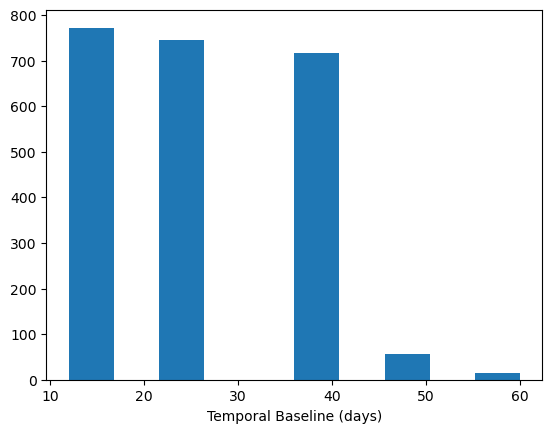

In [25]:
plt.hist(yy)
plt.xlabel('Temporal Baseline (days)')